In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import re
import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from utils import tools, callbacks, metrics, supported_preprocessing_transforms
from modules.cae_base_module import CAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from datasets import supported_datamodules
from models import supported_models
from functools import reduce

# Novel Region Extraction with Generic Reconstructions

Images of planetary landscapes contain incredible amounts of valuable information. This poses a problem for novelty detection. Since truly novel content may only take up a small fraction of the image, global image properties that may be useful for novelty detection are diluated by the other details in the landscape. This experiment seeks to address this limitation by implementing *novel region extraction*, the task of tagging regions in larger images and ranking them by novelty. We hypothesize that by using unsupervised object recognition to intelligently cropped regions, general reconstruction-based detection techniques can be repurposed into novel region extractors.

From a practical perspective, the region proposal step is implemented within the preprocessing pipeline. In the following code, the region proposal itself is called implicitly in the `supported_preprocessing_transforms`, the code for it is found in `utils/preprocessing.py`. Given the large computational burden placed on the CPU when region extraction  is used during preprocessing, it is easier to load the batch once and test each model serially than to test the models with their own dedicted dataloaders. One downside is that the batch size is static for all testing cycles; however, since batches are looped over in the `test_step` regardless of the model, this only affects the amount of data dropped in the final batch when the test size isn't divisible by the batch size.

In [2]:
# Import configurations and paths to logged models
root = Path.cwd() / '..' / '..'
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models_ss = list(Path(log_path).glob('**/archive_nre*'))
paths_to_archived_models_bing = list(Path(log_path).glob('**/archive_bing*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in (*paths_to_archived_models_ss, *paths_to_archived_models_bing)]))

Found archived models:
------
SimpleVAE/archive_nre1_2021-05-04
SimpleVAE/archive_nre2_2021-05-04
BaselineCAE/archive_nre1_2021-05-02
CompressionCAEHighCapacity/archive_nre1_2021-05-03
CompressionCAEMidCapacity/archive_nre1_2021-05-02
BaselineAAE/archive_nre1_2021-05-07
BaselineVAE/archive_bing1_2021-05-20
BaselineCAE/archive_bing1_2021-05-19
BaselineAAE/archive_bing1_2021-05-19


In [3]:
from experiments.helpers import load_modules

module_catalog_ss, datamodule_ss, _ = load_modules(paths_to_archived_models_ss)
module_catalog_bing, datamodule_bing, _ = load_modules(paths_to_archived_models_bing)

Loading state dict for: SimpleVAE/archive_nre1_2021-05-04
Loading state dict for: SimpleVAE/archive_nre2_2021-05-04
Loading state dict for: BaselineCAE/archive_nre1_2021-05-02
Loading state dict for: CompressionCAEHighCapacity/archive_nre1_2021-05-03
Loading state dict for: CompressionCAEMidCapacity/archive_nre1_2021-05-02
Loading state dict for: BaselineAAE/archive_nre1_2021-05-07
Loading state dict for: BaselineVAE/archive_bing1_2021-05-20
Loading state dict for: BaselineCAE/archive_bing1_2021-05-19
Loading state dict for: BaselineAAE/archive_bing1_2021-05-19


In [4]:
def rp_test_modules(datamodule, module_catalog):
    for batch_nb, batch in enumerate(datamodule.test_dataloader()):
        print(f'------\nLoaded batch {batch_nb}\n------')
                
        # Extract the model type (e.g. CAE, AAE, VAE) and their versions
        for model_type, model_versions in module_catalog.items():
            
            # Extract the name of the archive and the module's state dict
            for model_name, module in model_versions.items():
                
                # Set the model/components in evaluation mode
                if 'AAE' in model_type:
                    module.encoder.eval()
                    module.decoder.eval()
                else:
                    module.model.eval()
                
                short_name = model_type + '-' + model_name.split('_')[1]
                if short_name not in result_catalog:
                    result_catalog[short_name] = {
                        'scores': [], 
                        'filepaths': [],
                        'gt_bboxes': [],
                        'cr_bboxes': []
                    }
                print(f'Testing on: {short_name}')

                result = module.test_step(batch, batch_nb)
                
                result_catalog[short_name]['scores'].extend(result['scores'])
                result_catalog[short_name]['filepaths'].extend(result['labels']['filepaths'])
                result_catalog[short_name]['gt_bboxes'].extend(result['labels']['gt_bboxes'])
                result_catalog[short_name]['cr_bboxes'].extend(result['labels']['cr_bboxes'])
    return result_catalog
    
# Testing loop
# Caution: this loop takes _minutes_ to run.
start = time.time()

# Collect scores and labels for all models in a catalog
result_catalog = {}

# Loop over the test dataloader, using the same batch for each model to save time
with torch.no_grad():
    result_catalog_ss = rp_test_modules(datamodule_ss, module_catalog_ss)
    result_catalog_bing = rp_test_modules(datamodule_bing, module_catalog_bing)
                
print(f'Testing took: {time.time() - start:.2f}')

------
Loaded batch 0
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 1
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 2
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 3
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 4
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testi

------
Loaded batch 19
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 20
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 21
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 22
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 23
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 24
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 25
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
Testing took: 1636.76


In [6]:
# Merge the bing and ss results, but dataloaders are still seperate
result_catalog = {**result_catalog_ss, **result_catalog_bing}

# Format data for plotting and analysis
for sn, results in result_catalog.items():
    results['scores'] = np.array(results['scores'])
    results['filepaths'] = np.array(results['filepaths']).reshape(-1)
    results['gt_bboxes'] = np.array(results['gt_bboxes']).reshape(-1, 4)
    results['cr_bboxes'] = np.array(results['cr_bboxes']).reshape(-1, 4)
    print(f'[{sn}]\t Predicted {results["scores"].shape} scores, '\
          f'with {results["gt_bboxes"].shape} gt boxes, and {results["cr_bboxes"].shape} rps')

with open('nre-results_2021-05-05.pkl', 'wb') as f:
    pickle.dump(result_catalog, f)

[SimpleVAE-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[SimpleVAE-nre2]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineCAE-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[CompressionCAEHighCapacity-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[CompressionCAEMidCapacity-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineAAE-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineVAE-bing1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineCAE-bing1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineAAE-bing1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps


In [178]:
# Checkout the preprocessing transforms that were applied to the datamodules
print('Selective Search approach: ', datamodule_ss._data_transforms)
print('Saliency approach: ', datamodule_bing._data_transforms)

Selective Search approach:  Compose(
)
Saliency approach:  Compose(
)


# Region Proposal Analysis

In [8]:
%matplotlib inline

# For now, just run the analysis on all of the models
iou_results = {}

for sn, res in result_catalog.items():
    ious = []
    # binary_labels = []  # IOU > 0.5 counts as a label
    n_duplicates = 0
    n_novelties = 428
    iou_thresh = 0.5

    gt_bboxes = res['gt_bboxes']
    cr_bboxes = res['cr_bboxes']
    for i, (gt, cr) in enumerate(zip(gt_bboxes, cr_bboxes)):
        cr = cr * 5  # Rescale the bounding boxes, see 'scale' parameter in LunarAnaloguePreprocesing
        iou = metrics.iou(cr, gt)
        ious.append(iou)

        if i == 0:
            prev_gt = [-1, -1, -1, -1]
        if iou > iou_thresh:
            if all(gt == prev_gt):
                n_duplicates += 1
            prev_gt = gt
            
        if iou > iou_thresh and ('CAE-bing' in sn or 'CAE-nre' in sn):
            im = plt.imread((res['filepaths'][i]))
            fig, ax = plt.subplots()
            ax.imshow(im)
            gt_rect = patches.Rectangle((gt[0], gt[1]), gt[2], gt[3], edgecolor='C0', facecolor='none', lw=3)
            cr_rect = patches.Rectangle((cr[0], cr[1]), cr[2], cr[3], edgecolor='C1', facecolor='none', lw=3)
            ax.add_patch(gt_rect)
            ax.add_patch(cr_rect)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.savefig(f'overlaps-from-datamodule/GoodIOU-{sn}-iou={int(iou*100)}.png', bbox_inches='tight')
            plt.close()
            

    ious = np.array(ious)
    bin_labels = ious > iou_thresh
    
    print(f'------\n{sn}\n------')
    print(f'N labels: {sum(bin_labels)}')
    print(f'N duplicates: {n_duplicates}')
    print(f'N novelties: {n_novelties}')
    print(f'Ratio of located novelies {(sum(bin_labels) - n_duplicates)/n_novelties:.5f}')
    print(f'Ratio of relevant regions {sum(bin_labels) / (n_novelties*16):.5f}')
    
    iou_results[sn] = {
        'ious': ious, 
        'labels': bin_labels, 
        'scores': res['scores'], 
        'n_duplicates': n_duplicates,
        'n_novelties': n_novelties
    }

2021-05-24 09:03:34,265 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


------
SimpleVAE-nre1
------
N labels: 159
N duplicates: 15
N novelties: 428
Ratio of located novelies 0.33645
Ratio of relevant regions 0.02322
------
SimpleVAE-nre2
------
N labels: 159
N duplicates: 15
N novelties: 428
Ratio of located novelies 0.33645
Ratio of relevant regions 0.02322
------
BaselineCAE-nre1
------
N labels: 159
N duplicates: 15
N novelties: 428
Ratio of located novelies 0.33645
Ratio of relevant regions 0.02322
------
CompressionCAEHighCapacity-nre1
------
N labels: 159
N duplicates: 15
N novelties: 428
Ratio of located novelies 0.33645
Ratio of relevant regions 0.02322
------
CompressionCAEMidCapacity-nre1
------
N labels: 159
N duplicates: 15
N novelties: 428
Ratio of located novelies 0.33645
Ratio of relevant regions 0.02322
------
BaselineAAE-nre1
------
N labels: 159
N duplicates: 15
N novelties: 428
Ratio of located novelies 0.33645
Ratio of relevant regions 0.02322
------
BaselineVAE-bing1
------
N labels: 59
N duplicates: 4
N novelties: 428
Ratio of locate

In [46]:
plt.style.use('../../utils/_extras/primary.mplstyle')

fig, ax = plt.subplots(figsize=(10,10))
for sn, res in result_catalog.items():

    scores = res['scores']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, iou_results[sn]['labels'])
    
    ax.plot(fpr, tpr, label=f'{sn} AUC: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.legend(title='AUC', loc='upper left', bbox_to_anchor=(1.05, 1.))
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.savefig('ROC-all_LunarAnalogueRP.pdf', bbox_inches='tight')
plt.show()
print('Random ROC AUC: 0.5')

2021-05-24 13:57:42,007 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,007 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,007 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,008 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,008 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,009 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,009 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,009 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,010 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,010 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 13:57:42,046 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:42,047 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,048 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,048 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,049 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,049 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,049 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,049 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,050 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,050 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:

2021-05-24 13:57:42,092 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,095 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,098 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/5a1b54d1674e03d50d5b4e7398b6dfbf.dvi
2021-05-24 13:57:42,101 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,110 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,110 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,111 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,111 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,112 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,113 - DEBUG - Textile font is not compatible with

SimpleVAE-nre1: 947.8104695662623
SimpleVAE-nre2: 824.4180877240724
BaselineCAE-nre1: 119.62274187631556
CompressionCAEHighCapacity-nre1: 145.46293129012338
CompressionCAEMidCapacity-nre1: 125.881515183577
BaselineAAE-nre1: 358.9721502023749
BaselineVAE-bing1: 882.1682521426119
BaselineCAE-bing1: 85.1389648388722
BaselineAAE-bing1: 399.2102353082737


2021-05-24 13:57:42,136 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:42,137 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,137 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,138 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,138 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,140 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,141 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,141 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,141 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,141 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:

2021-05-24 13:57:42,190 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,191 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,191 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 13:57:42,192 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,193 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,193 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,194 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,194 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,194 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,195 - DEBUG - Textile font is not compatible with

2021-05-24 13:57:42,238 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,238 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,238 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,240 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,242 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:42,242 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,243 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,244 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,244 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,245 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 13:57:42,293 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,293 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,293 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,294 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,295 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,296 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,297 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/0d9b9ee831113e9aa9cba23b49a451b8.dvi
2021-05-24 13:57:42,298 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,301 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,302 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 13:57:42,352 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,353 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,353 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,353 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,353 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,354 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,354 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,354 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,355 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:42,356 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 13:57:42,447 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,447 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,448 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,448 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,448 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,448 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,449 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,449 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,449 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,450 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 13:57:42,493 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 13:57:42,493 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,494 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,495 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,495 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,495 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,496 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,496 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,497 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,497 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:

2021-05-24 13:57:42,549 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,550 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,550 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,551 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 13:57:42,552 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,554 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,554 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,555 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,555 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,555 - DEBUG - Apple Chancery font is not compat

2021-05-24 13:57:42,604 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,604 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,605 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,606 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,606 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,607 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:42,607 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,608 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,608 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,609 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 13:57:42,647 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,648 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,648 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,649 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,649 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,649 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,650 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,651 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 13:57:42,652 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,656 - DEBUG - family: serif, font: Palatino, info

2021-05-24 13:57:42,699 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,699 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,699 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,700 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,700 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,700 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,700 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,701 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,701 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,701 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dv

2021-05-24 13:57:42,749 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,750 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,750 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,750 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,751 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,751 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,751 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,751 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,755 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,756 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,758 - DEBUG - fam

2021-05-24 13:57:42,807 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,808 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:42,809 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,810 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,810 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,810 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,810 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,811 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:42,811 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,811 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 13:57:42,858 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,858 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,858 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,859 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bd71aa5ca7583134770cc4a0650e12f8.dvi
2021-05-24 13:57:42,860 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,862 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,863 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,864 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:42,864 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:42,864 - DEBUG - Apple Chancery font is not compat

2021-05-24 13:57:42,930 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:42,930 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:42,931 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,931 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:42,931 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:42,932 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/dda7b9793bc973ace509dddda4527575.dvi
2021-05-24 13:57:42,933 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:42,936 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:42,938 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:42,938 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 13:57:43,006 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,006 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,006 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,007 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,007 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,008 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,008 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,008 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b6a99a7a9f07fa58ccecb309ac093763.dvi
2021-05-24 13:57:43,009 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,011 - DEBUG - Embedding Type-1 font b'pplr8r' fro

2021-05-24 13:57:43,061 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,062 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 13:57:43,063 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,066 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,066 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,066 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,067 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,067 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,067 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,068 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 13:57:43,117 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,123 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,123 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,124 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,124 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,125 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,125 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,125 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,125 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,126 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 13:57:43,169 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,169 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,170 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,170 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,170 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,170 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,173 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,173 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,173 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,174 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 13:57:43,212 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,213 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,213 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,213 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,213 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/5a1b54d1674e03d50d5b4e7398b6dfbf.dvi
2021-05-24 13:57:43,215 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,216 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,217 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,217 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,217 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 13:57:43,263 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,263 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,264 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,264 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,264 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,264 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,265 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:43,266 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,266 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,266 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 13:57:43,303 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,303 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,303 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,303 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,304 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,304 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,304 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 13:57:43,306 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,307 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,308 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 13:57:43,337 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,338 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,338 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,338 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,339 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,339 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,339 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,339 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,340 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,340 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 13:57:43,380 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,380 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,381 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,381 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,381 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,381 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,382 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,383 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,384 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,384 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/02f722d3f1fe0334c4218f7b28d9566d.dv

2021-05-24 13:57:43,431 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,432 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,432 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,433 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,433 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,433 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,433 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,434 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,434 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,434 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,435 - DEBUG - fam

2021-05-24 13:57:43,477 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,478 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2641f191a59b5adb7a14f7a9028c50ea.dvi
2021-05-24 13:57:43,478 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,481 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,482 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,482 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,482 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,483 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,483 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,484 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 13:57:43,542 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,543 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,543 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,543 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,544 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,544 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,545 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,546 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,546 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,546 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 13:57:43,600 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,600 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,602 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,602 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,603 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,603 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,603 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,604 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,604 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,605 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 13:57:43,649 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,649 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,649 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bd71aa5ca7583134770cc4a0650e12f8.dvi
2021-05-24 13:57:43,650 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,653 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,653 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,654 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,654 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,657 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,657 - DEBUG - Textile font is not compatible with

2021-05-24 13:57:43,764 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 13:57:43,766 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,767 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,768 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,770 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,770 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,771 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,772 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,773 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,774 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:

2021-05-24 13:57:43,813 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,814 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,814 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 13:57:43,815 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,816 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,817 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,817 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,817 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,818 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,818 - DEBUG - Textile font is not compatible with

2021-05-24 13:57:43,863 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,863 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 13:57:43,864 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:43,864 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:43,864 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,865 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,866 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,866 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,866 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,867 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 13:57:43,913 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,913 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,913 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,913 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,914 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,914 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,914 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 13:57:43,915 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,916 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,916 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 13:57:43,967 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:43,967 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:43,967 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:43,968 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,969 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:43,969 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 13:57:43,969 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d57805ca30df78f885241e6b3aa903c5.dvi
2021-05-24 13:57:43,970 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 13:57:43,971 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 13:57:43,971 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 13:57:44,013 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 13:57:44,013 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 13:57:44,014 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 13:57:44,014 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 13:57:44,014 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 13:57:44,015 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 13:57:44,015 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 13:57:44,015 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_

2021-05-24 10:28:44,022 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:44,022 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:44,023 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:44,023 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:44,024 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:44,024 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:44,024 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:44,025 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:44,025 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:44,025 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 10:28:45,432 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:45,432 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:45,432 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:45,433 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,433 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,433 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:45,434 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:45,434 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:45,435 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:45,435 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:45,655 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:45,656 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:45,656 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,656 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,656 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:45,657 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:45,657 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:45,658 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:45,659 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:45,660 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 10:28:45,704 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:45,704 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:45,704 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:45,705 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:45,705 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,705 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,706 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:45,706 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-24 10:28:45,707 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:45,710 - DEBUG - family: serif, font: Palatino, info

2021-05-24 10:28:45,763 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:45,763 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:45,764 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:45,764 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:45,765 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:45,765 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:45,765 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,766 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:45,766 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:45,766 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dv

2021-05-24 10:28:45,986 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/fd69e030e9fdff251272102b14690348.dvi
2021-05-24 10:28:45,986 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:45,989 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:45,989 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:45,990 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:45,990 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:45,990 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:45,991 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:45,991 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:45,991 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:

2021-05-24 10:28:46,178 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:46,178 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:46,179 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:46,179 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:46,179 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:46,179 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:46,180 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:46,180 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:46,180 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:46,181 - DEBUG - latex -interaction=nonstopmode --halt-on-error /home/brahste/.cache/matplotlib/tex

2021-05-24 10:28:46,555 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9fa3464c915506160604c5d5c0886aea.dvi
2021-05-24 10:28:46,556 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:46,559 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:46,559 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:46,560 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:46,560 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:46,560 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:46,561 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:46,561 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:46,561 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:

2021-05-24 10:28:46,747 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:46,747 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:46,748 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:46,748 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:46,749 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:46,750 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:46,750 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:46,750 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:46,750 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:46,751 - DEBUG - latex -interaction=nonstopmode --halt-on-error /home/brahste/.cache/matplotlib/tex

2021-05-24 10:28:47,093 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6808a91b9552c552117dd864c6f1f9bf.dvi
2021-05-24 10:28:47,093 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:47,096 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:47,096 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:47,097 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:47,097 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:47,097 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:47,098 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:47,098 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:47,098 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:

2021-05-24 10:28:47,290 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:47,290 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:47,291 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:47,291 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:47,291 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:47,291 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:47,292 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:47,292 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:47,292 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:47,293 - DEBUG - latex -interaction=nonstopmode --halt-on-error /home/brahste/.cache/matplotlib/tex

2021-05-24 10:28:47,650 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bf81c3838555aec797f0ae560b88d63c.dvi
2021-05-24 10:28:47,651 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:47,652 - DEBUG - kpsewhich zplmr7t.tfm
2021-05-24 10:28:47,800 - DEBUG - stdout:
/usr/share/texlive/texmf-dist/fonts/tfm/public/mathpazo/zplmr7t.tfm

2021-05-24 10:28:47,801 - DEBUG - opening tfm file /usr/share/texlive/texmf-dist/fonts/tfm/public/mathpazo/zplmr7t.tfm
2021-05-24 10:28:47,801 - DEBUG - lh=18, bc=0, ec=170, nw=64, nh=16, nd=16
2021-05-24 10:28:47,802 - DEBUG - kpsewhich zplmr7t.vf
2021-05-24 10:28:47,946 - DEBUG - stdout:
/usr/share/texlive/texmf-dist/fonts/vf/public/mathpazo/zplmr7t.vf

2021-05-24 10:28:47,947 - DEBUG - Dvi: /usr/share/texlive/texmf-dist/fonts/vf/public/mathpazo/zplmr7t.vf
2021-05-24 10:28:47,948 - DEBUG - kpsewhich fplmr.tfm
2021-05-24 10:28:48,093 - DEBUG - stdout:
/usr/share/texlive/texmf-dist/fonts/tfm/public/mathpazo

2021-05-24 10:28:49,300 - DEBUG - kpsewhich uplri8a.pfb
2021-05-24 10:28:49,435 - DEBUG - stdout:
/usr/share/texlive/texmf-dist/fonts/type1/urw/palatino/uplri8a.pfb

2021-05-24 10:28:49,436 - DEBUG - Assigning font /b'F2' = b'pplri8r' (dvi)
2021-05-24 10:28:49,439 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,439 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,440 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,440 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,440 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,440 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:49,441 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,441 - DEBUG - DejaVu Sans Mono font is not compatible with 

2021-05-24 10:28:49,475 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,475 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:49,476 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:49,476 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:49,477 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,477 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,477 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,478 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,478 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,479 - DEBUG - Textile font is not compatible with

2021-05-24 10:28:49,514 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,515 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,515 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,515 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:49,516 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 10:28:49,516 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:49,518 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,518 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,518 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,518 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 10:28:49,558 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,559 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:49,559 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,560 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,560 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,560 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:49,561 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 10:28:49,561 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:49,563 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,564 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:49,604 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,605 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,605 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,606 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:49,606 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,606 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,607 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,607 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:49,608 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b57ee53f0ce2ac4ba13e94b113cf1751.dvi
2021-05-24 10:28:49,609 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 10:28:49,667 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,667 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,667 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,668 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,668 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,668 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:49,668 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,669 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,670 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,671 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 10:28:49,711 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:49,712 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:49,713 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,713 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,714 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,714 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,714 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,714 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:49,715 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,715 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:

2021-05-24 10:28:49,756 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,757 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:49,758 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/fe62cb34da95e342876f67a3d4ed0487.dvi
2021-05-24 10:28:49,758 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:49,761 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,761 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,762 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,762 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,762 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,763 - DEBUG - Textile font is not compatible with

2021-05-24 10:28:49,822 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:49,822 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,822 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:49,823 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:49,823 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9fa3464c915506160604c5d5c0886aea.dvi
2021-05-24 10:28:49,824 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:49,828 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,829 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,829 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,832 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 10:28:49,884 - DEBUG - Embedding Type-1 font b'pplri8r' from dvi.
2021-05-24 10:28:49,885 - DEBUG - Embedding TeX font b'pplri8r' - fontinfo={'dvifont': <DviFont: b'pplri8r'>, 'pdfname': <Name b'F2'>, 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/urw/palatino/uplri8a.pfb', 'basefont': b'URWPalladioL-Ital', 'encodingfile': '/usr/share/texlive/texmf-dist/fonts/enc/dvips/base/8r.enc', 'effects': {}}
2021-05-24 10:28:49,892 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:49,892 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:49,893 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:49,893 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:49,894 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:49,894 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 1

2021-05-24 10:28:49,929 - DEBUG - dvipng -bg Transparent -D 72.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/8fbf53fbd7591b7f5f77a94080ca268c.png /home/brahste/.cache/matplotlib/tex.cache/5c64c7ebc2bde02608cd3f7e7559b466.dvi
2021-05-24 10:28:50,093 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-24 10:28:50,094 - DEBUG - STREAM b'IHDR' 16 13
2021-05-24 10:28:50,095 - DEBUG - STREAM b'PLTE' 41 48
2021-05-24 10:28:50,095 - DEBUG - STREAM b'tRNS' 101 15
2021-05-24 10:28:50,095 - DEBUG - STREAM b'pHYs' 128 9
2021-05-24 10:28:50,095 - DEBUG - STREAM b'IDAT' 149 367
2021-05-24 10:28:50,097 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,097 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:50,097 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,097 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\use

2021-05-24 10:28:50,276 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,276 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,276 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,276 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,277 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,278 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,278 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/99dc8a34723ae4368597c34388a0a64f.dvi
2021-05-24 10:28:50,278 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:50,280 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,280 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:50,319 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,319 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,319 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,320 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,320 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,320 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,320 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9814159c3fac1cfbf0b21ea20703e45f.dvi
2021-05-24 10:28:50,321 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:50,322 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,322 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:50,363 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,365 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:50,365 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,366 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,366 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,366 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,367 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,367 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,367 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:50,367 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 10:28:50,435 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:50,436 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,436 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:50,437 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,437 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,438 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,438 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,438 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,439 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,439 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 10:28:50,495 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,495 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,496 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,496 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,496 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,496 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,498 - DEBUG - STREAM b'IHDR' 16 13
2021-05-24 10:28:50,498 - DEBUG - STREAM b'PLTE' 41 48
2021-05-24 10:28:50,499 - DEBUG - STREAM b'tRNS' 101 15
2021-05-24 10:28:50,499 - DEBUG - STREAM b'pHYs' 128 9
2021-05-24 10:28:50,499 - DEBUG - STREAM b'IDAT' 149 138
2021-05-24 10:28:50,501 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,501 - DEBUG -

2021-05-24 10:28:50,536 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,536 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,537 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,537 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,538 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,538 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,539 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 10:28:50,540 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:50,543 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,544 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:50,581 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,581 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,581 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,582 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,583 - DEBUG - STREAM b'IHDR' 16 13
2021-05-24 10:28:50,583 - DEBUG - STREAM b'PLTE' 41 48
2021-05-24 10:28:50,583 - DEBUG - STREAM b'tRNS' 101 15
2021-05-24 10:28:50,584 - DEBUG - STREAM b'pHYs' 128 9
2021-05-24 10:28:50,585 - DEBUG - STREAM b'IDAT' 149 687
2021-05-24 10:28:50,586 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,586 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:50,587 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,587 

2021-05-24 10:28:50,634 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:50,635 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,635 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,635 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,636 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,636 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,636 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,637 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be0b652c36ab7e4f5a2e49fe1562eada.dvi
2021-05-24 10:28:50,638 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:50,640 - DEBUG - family: serif, font: Palatino, info

2021-05-24 10:28:50,682 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:50,683 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,683 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:50,683 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,684 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,684 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,684 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,684 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,685 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,685 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 10:28:50,731 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:50,731 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:50,732 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:50,732 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,732 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:50,733 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,733 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,734 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,734 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,736 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,737 - DEBUG - fam

2021-05-24 10:28:50,789 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:50,789 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:50,789 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:50,790 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:50,790 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:50,791 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:50,792 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,792 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:50,794 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:50,795 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 10:28:51,113 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be0b652c36ab7e4f5a2e49fe1562eada.dvi
2021-05-24 10:28:51,114 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:51,117 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:51,117 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:51,118 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:51,118 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:51,118 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:51,119 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:51,119 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:51,119 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:

2021-05-24 10:28:51,423 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-24 10:28:51,424 - DEBUG - STREAM b'IHDR' 16 13
2021-05-24 10:28:51,425 - DEBUG - STREAM b'PLTE' 41 48
2021-05-24 10:28:51,425 - DEBUG - STREAM b'tRNS' 101 15
2021-05-24 10:28:51,425 - DEBUG - STREAM b'pHYs' 128 9
2021-05-24 10:28:51,426 - DEBUG - STREAM b'IDAT' 149 1131
2021-05-24 10:28:51,427 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:51,427 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:51,427 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:51,428 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:51,428 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:51,428 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:51,429 - DEBUG - family: cursive, f

2021-05-24 10:28:51,599 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:51,600 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:51,600 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:51,601 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:51,601 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:51,601 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:51,601 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:51,602 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:51,602 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:51,602 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 10:28:51,914 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:51,914 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:51,914 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:51,915 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:51,915 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:51,915 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:51,915 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:51,916 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:51,916 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:51,916 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 

2021-05-24 10:28:52,227 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,227 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,227 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,228 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,228 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,228 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,228 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/fe62cb34da95e342876f67a3d4ed0487.dvi
2021-05-24 10:28:52,230 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,233 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,233 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:52,453 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,453 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,453 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,454 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,454 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,454 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,454 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,455 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,456 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:52,456 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 10:28:52,487 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,487 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,488 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,488 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,488 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,489 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,489 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/99dc8a34723ae4368597c34388a0a64f.dvi
2021-05-24 10:28:52,490 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,490 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,491 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:52,520 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,520 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,521 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,522 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,522 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,522 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,522 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:52,523 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,524 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,525 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 10:28:52,563 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,563 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,564 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,565 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,565 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,565 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,566 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,566 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,566 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 10:28:52,567 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 10:28:52,607 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,607 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,607 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,607 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,608 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,608 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,608 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,609 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,609 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,611 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 10:28:52,647 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,648 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,648 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,649 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,649 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,650 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,650 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,650 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,651 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,651 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,651 - DEBUG - fam

2021-05-24 10:28:52,701 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,701 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,702 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,702 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,702 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,702 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,703 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,703 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,703 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,704 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f377b81fb10b258ec34fde8943503ec.dv

2021-05-24 10:28:52,747 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,749 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,750 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,750 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,750 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,750 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,751 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,751 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,751 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,751 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,752 - DEBUG - fam

2021-05-24 10:28:52,798 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,798 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 10:28:52,799 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,799 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,804 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,805 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,805 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,806 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,806 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,806 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 10:28:52,848 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,848 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,849 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,849 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bf81c3838555aec797f0ae560b88d63c.dvi
2021-05-24 10:28:52,851 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 10:28:52,857 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,858 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,859 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,859 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,860 - DEBUG - Apple Chancery font is not compat

2021-05-24 10:28:52,913 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,914 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,914 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,914 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,914 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 10:28:52,915 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,915 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,915 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,915 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,916 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/485c0a1dc54a2a1a4397ce293980dc4d.dv

2021-05-24 10:28:52,966 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 10:28:52,966 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,966 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 10:28:52,967 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 10:28:52,968 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 10:28:52,968 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 10:28:52,969 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 10:28:52,970 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 10:28:52,970 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 10:28:52,971 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 

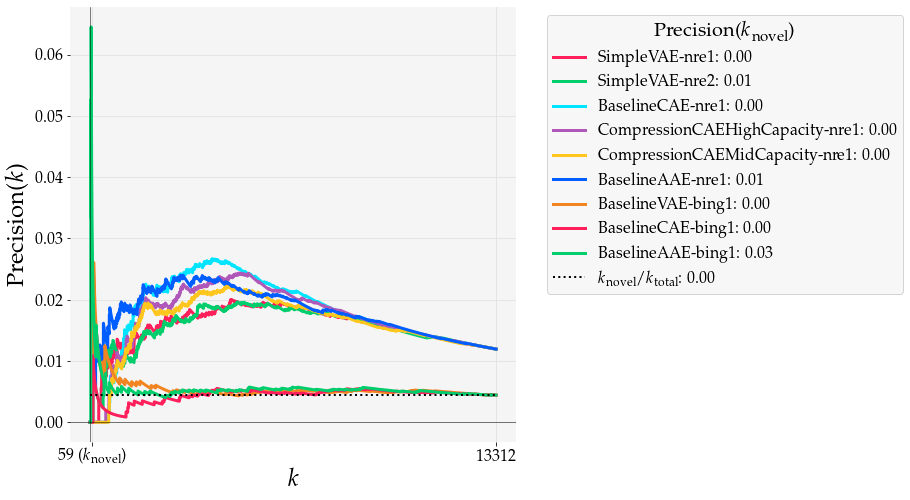

In [18]:
# Plot the Precision(k) across all test images.
# THIS METRIC SHOULD BE OMITTED HERE BECAUSE IT'S MISLEADING

fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    scores = results['scores']
    labels = iou_results[sn]['labels']
    pak = metrics.precision_at_k(scores, iou_results[sn]['labels'])

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()

    ax.plot(pak, label=f'{sn}: {pak[int(sum(labels))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-all_LunarAnalogueRP.pdf', format='pdf', bbox_inches='tight')
plt.show()

2021-05-24 14:43:46,244 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,244 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,245 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,245 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,246 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,246 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,246 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,247 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,247 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,247 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:46,277 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:46,278 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,279 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,280 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,280 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,281 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,282 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,282 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,282 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,283 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:46,319 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,319 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,320 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:43:46,320 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,321 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,322 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,322 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,322 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,323 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,323 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:46,385 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,385 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,386 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,386 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,387 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:46,387 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,388 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,388 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,389 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,389 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:46,430 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,431 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,431 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,432 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,432 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,432 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,433 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-24 14:43:46,433 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,436 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:46,616 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,616 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,617 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,617 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,617 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,617 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,618 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,618 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,618 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:46,619 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:46,651 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,651 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,652 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,652 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,652 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,652 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,653 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,653 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,653 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,653 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:46,698 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:43:46,699 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,699 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,700 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,700 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,701 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,701 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,701 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,701 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,702 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:46,744 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,744 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,745 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,745 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:46,746 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,746 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,747 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,747 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,750 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,750 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:46,789 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,789 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,789 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,789 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,790 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,790 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c2ad046775c699d06e76946f22922358.dvi
2021-05-24 14:43:46,791 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,792 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:46,792 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,793 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:46,834 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,834 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,835 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,835 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,835 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,836 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,836 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,836 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-24 14:43:46,837 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,839 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:46,886 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:46,886 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:46,887 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,887 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,887 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,888 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,888 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,890 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,894 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,894 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dv

2021-05-24 14:43:46,984 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:46,985 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:46,985 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:46,985 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:46,986 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,987 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:46,987 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:46,987 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:43:46,988 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:46,989 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:47,028 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,029 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,029 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,029 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,030 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,030 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,031 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,031 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,032 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,033 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:47,067 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,067 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,068 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,069 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,070 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d57805ca30df78f885241e6b3aa903c5.dvi
2021-05-24 14:43:47,071 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,072 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,073 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,074 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,074 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:47,113 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,114 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,114 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,115 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,115 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,115 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,116 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,116 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,116 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,117 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:43:47,167 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,167 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,167 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-24 14:43:47,168 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,169 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,169 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,170 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,170 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,170 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,171 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:47,213 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,214 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,214 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,214 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,215 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:47,215 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,216 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,217 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,217 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,219 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:47,267 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-24 14:43:47,268 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,269 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,270 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,270 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,271 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,271 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,271 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,272 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,272 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:47,308 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,309 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,309 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,309 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,309 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,310 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,311 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:43:47,312 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,315 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,315 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:47,357 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,357 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,360 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,361 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,361 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,362 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,362 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:47,364 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,365 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,366 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:47,579 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,580 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,580 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,580 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:43:47,581 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,582 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,582 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,583 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,583 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,583 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:47,614 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,614 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,614 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,614 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,615 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,615 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:47,616 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,617 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,617 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,617 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:47,657 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d57805ca30df78f885241e6b3aa903c5.dvi
2021-05-24 14:43:47,659 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,660 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,661 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,661 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,661 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,661 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,662 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,662 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,662 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:47,724 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,725 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,725 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,726 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,726 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,726 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,728 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,728 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,728 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:43:47,730 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:47,774 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,775 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,775 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,775 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,775 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,776 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,776 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,776 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,776 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,777 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:47,816 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:47,817 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,818 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,818 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,819 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,819 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,819 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,820 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,820 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,820 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:47,866 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,866 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,867 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,867 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,868 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:47,868 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,868 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:47,872 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,876 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,877 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 

2021-05-24 14:43:47,923 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,923 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:43:47,924 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,926 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,926 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,927 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,927 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,927 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,928 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,928 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:47,965 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:47,966 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:47,966 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:47,967 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:47,968 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:47,968 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:47,968 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:47,968 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:47,969 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:47,969 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

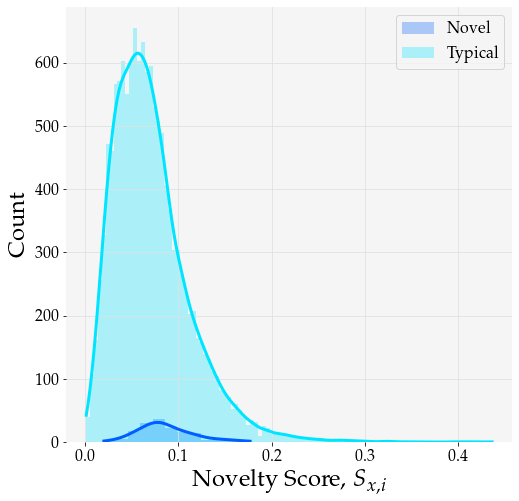

2021-05-24 14:43:48,267 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:48,267 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:48,268 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:48,268 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:48,269 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:48,269 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:48,269 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:48,269 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,270 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,270 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:48,302 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:48,303 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:48,304 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:48,304 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:48,304 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:48,305 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:48,305 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:48,305 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:48,305 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:48,306 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:48,350 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,350 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:48,351 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:43:48,351 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:48,352 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:48,353 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:48,353 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:48,353 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:48,354 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:48,354 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:48,391 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:48,392 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,392 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,392 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:48,393 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:48,393 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:48,394 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:48,395 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:48,395 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:48,396 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:48,435 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:48,435 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:48,436 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:48,436 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,436 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,436 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:48,437 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aeca9cc160489c2e86ad23daafdc741a.dvi
2021-05-24 14:43:48,438 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:48,443 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:48,444 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:48,637 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:48,638 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:48,638 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:48,638 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:48,638 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:48,639 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,639 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,639 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:48,639 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:48,640 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:48,682 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:48,683 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:48,683 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:48,683 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:48,683 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:48,684 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:48,684 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:48,684 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,684 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:48,685 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:49,753 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:49,753 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:49,754 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:49,754 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:49,754 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:49,755 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:49,755 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:49,756 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:49,756 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:49,756 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:49,756 - DEBUG - fam

2021-05-24 14:43:49,799 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:49,800 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-24 14:43:49,800 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:49,801 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:49,802 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:49,802 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:49,802 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:49,803 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:49,803 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:49,803 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:49,852 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:49,853 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:49,854 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:49,854 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:49,855 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:49,856 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:49,856 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:49,857 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:49,857 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:49,857 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:50,018 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,019 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,019 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,021 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,021 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,022 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:50,022 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,023 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,026 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,026 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:50,064 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,065 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,065 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,065 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,066 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,066 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,066 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,067 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:50,068 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,068 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:50,116 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,116 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,116 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,117 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,117 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,117 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,118 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,118 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,118 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,118 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:50,171 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:43:50,171 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,173 - DEBUG - Assigning font /b'F2' = b'pplri8r' (dvi)
2021-05-24 14:43:50,178 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,179 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,179 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,179 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,180 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,181 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,181 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,181 - 

2021-05-24 14:43:50,221 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,221 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,222 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,222 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:50,223 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,223 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,224 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,224 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,225 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,225 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:50,270 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,270 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,270 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,271 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,271 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,272 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:43:50,272 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,275 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,277 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,278 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:50,329 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,329 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,330 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,330 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,331 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,331 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,331 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,332 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:43:50,333 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,336 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:50,381 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,383 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,384 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,384 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,384 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,385 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,386 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,386 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,386 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,387 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dv

2021-05-24 14:43:50,476 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,477 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,477 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,477 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,478 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,478 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,478 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,479 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:50,480 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,481 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:50,519 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,519 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,519 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,520 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,520 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,520 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,521 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,522 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,522 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,522 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:50,559 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,559 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,560 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,560 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,560 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,560 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,561 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:50,562 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,564 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,565 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:50,602 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,602 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,603 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,603 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,603 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,604 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,604 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,604 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,605 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,605 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:43:50,654 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,654 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,655 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,655 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,655 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,656 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,656 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,656 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,657 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,657 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:50,692 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,693 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,694 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,694 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,694 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,695 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,696 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,696 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,696 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,697 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,697 - DEBUG - fam

2021-05-24 14:43:50,735 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,735 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:43:50,736 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,738 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,739 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,739 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,739 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,740 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,740 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,740 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:50,783 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,783 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,784 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,784 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:50,784 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,785 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,786 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,786 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-24 14:43:50,787 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,788 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:50,834 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,834 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,834 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,835 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:43:50,836 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,838 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,838 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,838 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,839 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,839 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:50,881 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,882 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:50,882 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,883 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:43:50,883 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,899 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,899 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,900 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,900 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,901 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:50,955 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:50,956 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:50,956 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:50,958 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:50,958 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:50,958 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:50,959 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:50,959 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:50,961 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:50,963 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:51,000 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,001 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,001 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,001 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:43:51,002 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,006 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,006 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,007 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,007 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,007 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:51,042 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,043 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,043 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,044 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,044 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,045 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:51,046 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,046 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,047 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,048 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:51,086 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,086 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,086 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,087 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,087 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,087 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,087 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,088 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c6f9e34e1befa64719a05f81a2d78e74.dvi
2021-05-24 14:43:51,089 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,090 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:51,137 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,137 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,138 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,138 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,139 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,139 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,139 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,139 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,140 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,140 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:51,319 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,320 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,320 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,321 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,321 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,321 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,322 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,322 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,323 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,323 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,323 - DEBUG - fam

2021-05-24 14:43:51,358 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,358 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:43:51,359 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,361 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,362 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,362 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,363 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,364 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,364 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,365 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:51,401 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,401 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,402 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,402 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,403 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,404 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,405 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,406 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/0e9cf75fab9c01f6cd9a63a91b8e7e3b.dvi
2021-05-24 14:43:51,411 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,412 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:51,457 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,457 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,458 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,458 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,458 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,459 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:51,460 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,461 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,461 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,461 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:51,500 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,500 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,501 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,501 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,501 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,501 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,502 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,502 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3f4bcc55be4a0fd2d33bdcf3e9c04e00.dvi
2021-05-24 14:43:51,503 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,504 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:51,536 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,537 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,537 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,537 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,537 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,538 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,539 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,540 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,540 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,541 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:51,580 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,581 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,581 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,581 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,582 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50eec38d441c8ed960a0cc999ea4df86.dvi
2021-05-24 14:43:51,583 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,584 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,585 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,585 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,586 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:51,625 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,625 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,626 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,626 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,626 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,627 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,627 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,627 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,628 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,628 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:51,668 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,668 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,669 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,669 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,669 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,670 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,670 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,670 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,670 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:51,671 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:51,739 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,739 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,739 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,740 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,740 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,741 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:51,741 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:43:51,742 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


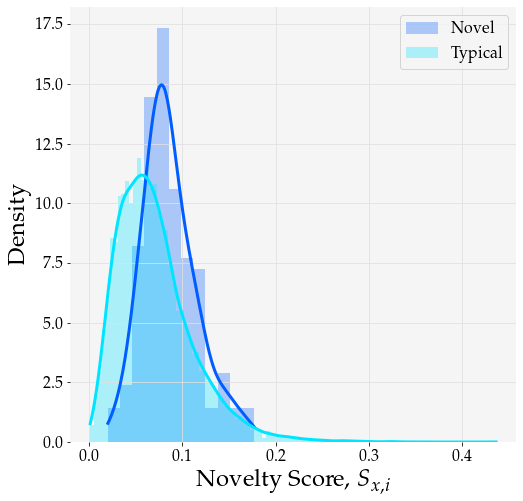

2021-05-24 14:43:51,774 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,774 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,775 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,775 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,775 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,776 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,776 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,776 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,777 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:51,778 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:51,817 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:51,818 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:51,818 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:51,819 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:51,819 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:51,819 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:51,820 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:51,820 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:51,820 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:51,820 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:53,237 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,238 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,238 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,238 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,239 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,239 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,239 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,239 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,240 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:53,241 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:53,266 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,268 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,269 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,269 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,269 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,269 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,270 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,270 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,270 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,270 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:53,302 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,302 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,303 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,303 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,303 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,304 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,304 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,304 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,304 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:53,306 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:53,339 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,340 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,340 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,340 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,341 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,341 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,341 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,342 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,342 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,343 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:43:53,386 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:53,389 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,391 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,393 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,394 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,394 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,395 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,395 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,396 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,396 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,396 - DEBUG - fam

2021-05-24 14:43:53,432 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,433 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:53,434 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:53,435 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,435 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,436 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,438 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,438 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,438 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,438 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:53,475 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,475 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,475 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,476 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/cfb8be411b49bc3eeb4565f8ea08805b.dvi
2021-05-24 14:43:53,477 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:53,478 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,479 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,479 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,480 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,480 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:53,520 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,520 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,520 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,520 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,521 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,521 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,521 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,522 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,522 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,522 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:43:53,563 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,563 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,564 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,564 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,564 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,565 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,565 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,565 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,565 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,566 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 

2021-05-24 14:43:53,605 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,606 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,606 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,606 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-24 14:43:53,607 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:53,610 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,610 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,611 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,611 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,612 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:53,665 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,665 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,666 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,666 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,667 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,667 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,667 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,667 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:53,668 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,668 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:43:53,932 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,933 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,933 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,933 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:43:53,934 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:53,935 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,938 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,938 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:53,938 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:53,939 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:53,976 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:53,976 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:53,977 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,977 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:53,977 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:53,978 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:43:53,978 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:53,979 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:53,979 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:53,979 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:54,018 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,018 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,018 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,019 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,019 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,019 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,019 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,021 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-24 14:43:54,021 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,022 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:54,065 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,065 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,065 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,065 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,066 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,066 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,066 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,066 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,067 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,067 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:54,221 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,222 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,222 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,222 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,223 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,223 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,223 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,224 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,224 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,224 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,225 - DEBUG - fam

2021-05-24 14:43:54,255 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,256 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:43:54,257 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,258 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,258 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,259 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,259 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,259 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,260 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,260 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:54,305 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,305 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,305 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,306 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,306 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:43:54,309 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,312 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,312 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,313 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,313 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:54,354 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,354 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,354 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,355 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,356 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,359 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,359 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,360 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:54,360 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,361 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:54,405 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,405 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,406 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,406 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,406 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,406 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,407 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,407 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,408 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,408 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/63ca6e0be05709794b698f3f5833e43e.dv

2021-05-24 14:43:54,459 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,460 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,460 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,461 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,461 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,462 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,462 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,462 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,462 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,463 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,464 - DEBUG - fam

2021-05-24 14:43:54,521 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,522 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:43:54,523 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,526 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,527 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,527 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,527 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,528 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,528 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,528 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:54,595 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:54,596 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,597 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,597 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,597 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,598 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,598 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,599 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,599 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,600 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:54,633 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,634 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,634 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:54,635 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,637 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,637 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,637 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,638 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,638 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,638 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:54,678 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,678 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,679 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,679 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,679 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,680 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,680 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,680 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,680 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-24 14:43:54,681 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:54,718 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,718 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,719 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,720 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,720 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,720 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,721 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,721 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,722 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,722 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:54,761 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,761 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,762 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,762 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,763 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,764 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,766 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-24 14:43:54,767 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,770 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,770 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:54,805 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,805 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,806 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,806 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,806 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,807 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,807 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,807 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,808 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,808 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:54,849 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,851 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,851 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,851 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,852 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,852 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,852 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,853 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,853 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,853 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,854 - DEBUG - fam

2021-05-24 14:43:54,895 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:54,896 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:54,896 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,896 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,897 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,898 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,898 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,898 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,898 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,899 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,899 - DEBUG - fam

2021-05-24 14:43:54,968 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:54,968 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:54,968 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:54,968 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:54,969 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:54,969 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:54,969 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,970 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:54,970 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:54,970 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:55,011 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:55,012 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:55,013 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:55,014 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:55,014 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:55,014 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:55,014 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:55,015 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:55,015 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,015 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,016 - DEBUG - fam

2021-05-24 14:43:55,058 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:55,058 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:43:55,059 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:55,062 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:55,063 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:55,063 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:55,063 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:55,063 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:55,064 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:55,064 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:55,104 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,104 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,105 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:55,105 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:55,106 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:55,106 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:55,110 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:55,110 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:55,111 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:55,111 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:55,144 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:55,144 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:55,145 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,145 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,146 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:55,146 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/cfb8be411b49bc3eeb4565f8ea08805b.dvi
2021-05-24 14:43:55,147 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:55,149 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:55,150 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:55,150 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:55,191 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:55,193 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:55,194 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:55,194 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:55,195 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,195 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:55,195 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:55,196 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:55,197 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:55,197 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:55,354 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:55,355 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:55,355 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:55,355 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:55,356 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:55,357 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:55,357 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2021-05-24 14

2021-05-24 14:43:56,709 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:56,709 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:56,709 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:56,710 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:56,710 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:56,710 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:56,711 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:56,711 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,711 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,712 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:56,751 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-24 14:43:56,752 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:56,754 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:56,755 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:56,755 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:56,755 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:56,756 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:56,756 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:56,756 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:56,756 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:56,796 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,797 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,797 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:56,798 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:43:56,798 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:56,799 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:56,800 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:56,801 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:56,802 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:56,802 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:56,836 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:56,836 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:56,836 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,836 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,837 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:56,837 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:56,837 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:56,838 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:56,838 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:56,839 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:56,874 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:56,874 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:56,874 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:56,874 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:56,875 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,875 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,875 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:56,875 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3220faf6b0d3737196ba522b1121d87d.dvi
2021-05-24 14:43:56,877 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:56,879 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:56,919 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:56,920 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:56,920 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:56,920 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:56,921 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:56,921 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:56,921 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,922 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:56,922 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:56,923 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dv

2021-05-24 14:43:57,004 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,004 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,004 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,005 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,005 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,005 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,005 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,006 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:43:57,007 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,008 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:57,044 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,047 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,047 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,048 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,048 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,048 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,049 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,049 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,050 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,050 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:43:57,089 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,089 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,089 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,090 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,091 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,092 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,092 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9814159c3fac1cfbf0b21ea20703e45f.dvi
2021-05-24 14:43:57,093 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,094 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,095 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:57,127 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,128 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,128 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,129 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,129 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,129 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,129 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,130 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,131 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,131 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:43:57,170 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,171 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,171 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,171 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,172 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,172 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,173 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,173 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,173 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,174 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,174 - DEBUG - fam

2021-05-24 14:43:57,207 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,208 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:57,208 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,210 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,211 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,212 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,212 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,212 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,213 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,214 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:43:57,248 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,250 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,250 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,251 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,251 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,251 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,251 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,252 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,252 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,253 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,253 - DEBUG - fam

2021-05-24 14:43:57,289 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,289 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,290 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,290 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,290 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-24 14:43:57,291 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,293 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,294 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,294 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,294 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:57,329 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,329 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,330 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,330 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,331 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:57,331 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,332 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,332 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,333 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,333 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:57,595 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,595 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,596 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:43:57,597 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,598 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,598 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,598 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,599 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,599 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,599 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:57,635 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,635 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,636 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,636 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,636 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:57,637 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,638 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,639 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,640 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,640 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:57,679 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,679 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,680 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,680 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,681 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,681 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,682 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:43:57,682 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,689 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,689 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:57,729 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,729 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,729 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,730 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,730 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,731 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,731 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,731 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,732 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:57,732 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:57,769 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,769 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,770 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,770 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,770 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,770 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,771 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,771 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,771 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,771 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:57,933 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:43:57,933 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,935 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,935 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,935 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,936 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,936 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,936 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:57,936 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:57,937 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:57,973 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:57,973 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:57,973 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:57,975 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:57,975 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:57,976 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:57,976 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:57,976 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:57,976 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:57,977 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:58,014 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,018 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,019 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,019 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,020 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,020 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9814159c3fac1cfbf0b21ea20703e45f.dvi
2021-05-24 14:43:58,021 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,022 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,023 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,023 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:58,065 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,065 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,066 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,066 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,067 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,067 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,068 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,068 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:43:58,069 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,071 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:43:58,109 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,109 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,110 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,110 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,110 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,111 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,111 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,111 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,111 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,112 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:43:58,147 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/4ff63694d246f86ff53a1409e4bb20ed.dvi
2021-05-24 14:43:58,148 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,152 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,153 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,153 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,154 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,154 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,154 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,155 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,155 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:43:58,199 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,199 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,199 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:43:58,200 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,201 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,201 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,201 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,202 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,202 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,202 - DEBUG - Textile font is not compatible with

2021-05-24 14:43:58,250 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,250 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,251 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,251 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,252 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:43:58,252 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,254 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,258 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,259 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,260 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:43:58,317 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,319 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,320 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,321 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:58,321 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,322 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,322 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,322 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,323 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,323 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:43:58,359 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,359 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,359 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,359 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,360 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,360 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-24 14:43:58,360 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,364 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,364 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,364 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:43:58,400 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,400 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,401 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,401 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,401 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,402 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,402 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,402 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,403 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,404 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:43:58,441 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,441 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,442 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,442 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,442 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,442 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,443 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,443 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,443 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,443 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 14:43:58,491 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,491 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,491 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,492 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,492 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,492 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,492 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:43:58,493 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,495 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,495 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:58,534 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,534 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,534 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,535 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,535 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,535 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,535 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,536 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,537 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:43:58,537 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:43:58,572 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,573 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,573 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,574 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,574 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,575 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,576 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-24 14:43:58,577 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:43:58,581 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,581 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:43:58,612 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:43:58,613 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:43:58,613 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:43:58,613 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:43:58,614 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:43:58,614 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:43:58,615 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:43:58,615 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:43:58,616 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:43:58,616 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:00,072 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,072 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,073 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,073 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,073 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,073 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,074 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,074 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,074 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,074 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3220faf6b0d3737196ba522b1121d87d.dv

2021-05-24 14:44:00,104 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,106 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,107 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,107 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,107 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,110 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,110 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,111 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,112 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,112 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,112 - DEBUG - fam

2021-05-24 14:44:00,263 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,263 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:00,263 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,264 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,264 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,265 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,265 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,265 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,265 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,266 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:00,301 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,301 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,302 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,302 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:44:00,303 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,304 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,305 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,305 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,305 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,306 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:00,346 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,346 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,346 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,347 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,347 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,348 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,348 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:44:00,349 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,350 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,351 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:00,390 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,391 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,391 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,391 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,391 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,392 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,392 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,393 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,393 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:00,394 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:00,434 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,436 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,437 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,437 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,438 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,439 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,439 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,440 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,440 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,440 - DEBUG - fam

2021-05-24 14:44:00,477 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,478 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:44:00,479 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,481 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,481 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,482 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,482 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,482 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,482 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,483 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:00,528 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,528 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,528 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,529 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-24 14:44:00,530 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,531 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,531 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,532 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,532 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,532 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:00,591 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,591 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,591 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,592 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,592 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,592 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:44:00,593 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,595 - DEBUG - Embedding Type-1 font b'pplr8r' from dvi.
2021-05-24 14:44:00,595 - DEBUG - Embedding TeX font b'pplr8r' - fontinfo={'dvifont': <DviFont: b'pplr8r'>, 'pdfname': <Name b'F1'>, 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/urw/palatino/uplr8

2021-05-24 14:44:00,659 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,660 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,661 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,661 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:44:00,662 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,663 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,663 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,664 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,664 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,664 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:00,701 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,702 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,702 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,702 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,703 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,703 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:00,704 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,705 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,706 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,706 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:00,741 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:44:00,742 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,743 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,744 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,744 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,745 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,745 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,745 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,745 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,746 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:00,784 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,785 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,785 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,785 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,785 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,786 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,786 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:44:00,787 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,790 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,790 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:00,829 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,830 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,830 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,831 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,831 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,831 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,832 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:00,833 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,833 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,834 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:00,874 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,874 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,874 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,875 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,875 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,875 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,876 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,876 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,876 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9a1cd5f6f69715f9ab1f4e024d553a53.dvi
2021-05-24 14:44:00,877 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:00,921 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,921 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,921 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,922 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,922 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,923 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:00,923 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,923 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,924 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,924 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:00,957 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,960 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,960 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,960 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,961 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,961 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,961 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,962 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,962 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,962 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,962 - DEBUG - fam

2021-05-24 14:44:00,996 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:00,997 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:00,997 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:00,997 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:00,997 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:00,998 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:00,998 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:00,999 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:00,999 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:00,999 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,000 - DEBUG - fam

2021-05-24 14:44:01,224 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,224 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,225 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,225 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,225 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,226 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,226 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,226 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,226 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,227 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:44:01,264 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,265 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,265 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,265 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,266 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,266 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,266 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,266 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,267 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,267 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,267 - DEBUG - fam

2021-05-24 14:44:01,306 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,306 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:01,307 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,310 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,311 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,311 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,312 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,312 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,312 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,312 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:01,350 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,350 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,351 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,351 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:01,352 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,353 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,353 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,353 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,355 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,355 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:01,393 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,393 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,393 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,394 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,394 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,395 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/44d121e228730617358c89d6eb164f5d.dvi
2021-05-24 14:44:01,395 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,401 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,401 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,402 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:01,558 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,558 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,558 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,558 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,559 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,559 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,559 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,560 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:01,561 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,561 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:01,597 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,597 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,598 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,598 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,598 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,598 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,599 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,599 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,599 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,600 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dv

2021-05-24 14:44:01,643 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,644 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,645 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,645 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,645 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,646 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,646 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,646 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,647 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,647 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,647 - DEBUG - fam

2021-05-24 14:44:01,698 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,699 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:44:01,700 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,703 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,703 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,704 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,704 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,704 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,705 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,705 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:01,743 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,743 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,743 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,744 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,745 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-24 14:44:01,746 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,747 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,747 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,747 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,748 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:01,780 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,781 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,781 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,781 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,782 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,782 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,783 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:01,783 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:01,784 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,785 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:01,826 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,827 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,827 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,827 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,828 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,828 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,828 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,829 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,829 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:44:01,830 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:01,878 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,879 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,879 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,880 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,880 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,880 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,880 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,881 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,881 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,881 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:01,954 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,954 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,954 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,955 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,956 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,956 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,957 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,957 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:01,957 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:01,958 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:01,993 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:01,994 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:01,994 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:01,994 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:01,995 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:01,995 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:01,995 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:01,996 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,996 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:01,996 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:02,031 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:44:02,032 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:02,034 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:02,034 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:02,035 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:02,037 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:02,038 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:02,038 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:02,038 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:02,038 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:02,077 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:02,078 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:02,078 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:02,078 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:02,078 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:02,079 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:02,079 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-24 14:44:02,080 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:02,082 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:02,082 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:02,126 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:02,127 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:02,128 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:02,128 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:02,129 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:02,129 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:02,129 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:02,130 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:02,130 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:02,130 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:03,421 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,421 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,421 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,422 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:03,422 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,423 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,424 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,424 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:03,424 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:03,424 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:03,451 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,451 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,451 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,452 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,452 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,452 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/44d121e228730617358c89d6eb164f5d.dvi
2021-05-24 14:44:03,452 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,455 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,455 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,455 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:03,481 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,481 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,481 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:03,482 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:03,482 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,482 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,482 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,483 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,483 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,483 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:03,512 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,513 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,513 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,513 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,513 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,514 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,514 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:03,515 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,515 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,516 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:03,543 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,543 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,543 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,544 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,544 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,544 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,544 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:44:03,545 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,558 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,559 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

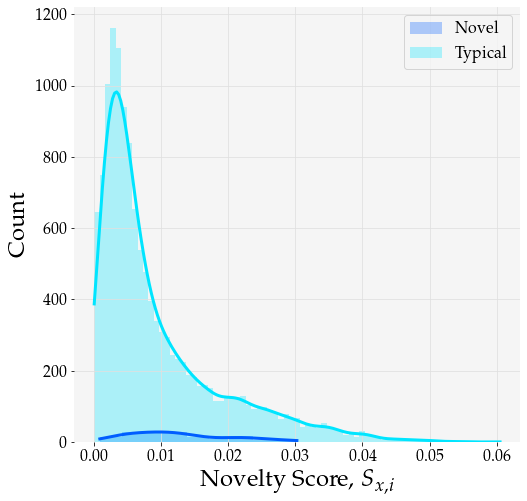

2021-05-24 14:44:03,824 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,825 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,825 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:03,825 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:03,825 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,826 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,826 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,826 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,827 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,827 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:03,869 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:03,869 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,870 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,870 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,871 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:03,871 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:03,871 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,871 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,872 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,872 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:03,908 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,908 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,909 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:44:03,909 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,915 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,916 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,917 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:03,919 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:03,920 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,920 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:03,957 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,957 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,957 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,958 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,959 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:03,959 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:03,960 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:03,960 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:03,960 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:03,961 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:03,991 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:03,991 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:03,992 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:03,992 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,993 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:03,993 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:03,994 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-24 14:44:03,995 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,002 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,003 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:04,160 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,160 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,160 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,161 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,162 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,162 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,162 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,163 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,163 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:04,164 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:04,202 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,203 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,203 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,203 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,203 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,204 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,204 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,205 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,205 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,205 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:04,238 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:44:04,239 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,241 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,242 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,242 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,242 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,243 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,243 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,243 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,243 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:04,287 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,287 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,287 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,288 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:44:04,289 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,291 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,291 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,292 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,292 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,293 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:04,334 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,334 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,334 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,335 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,335 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,335 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,336 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/11d3f079bac7ef456ad4fcfef7ec6c36.dvi
2021-05-24 14:44:04,337 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,337 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,338 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:04,370 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,370 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,370 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,371 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,371 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,371 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,372 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,372 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,372 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:04,374 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:04,414 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,415 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,416 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,416 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,416 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,416 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,417 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,417 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,417 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,418 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:04,459 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:04,459 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,460 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,460 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,460 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,461 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,461 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,462 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,462 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,463 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:04,539 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,540 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,540 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,540 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,541 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,541 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,541 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,542 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,542 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,542 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,543 - DEBUG - fam

2021-05-24 14:44:04,579 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,579 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:44:04,579 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,580 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,581 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,582 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,583 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,583 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,585 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,585 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:04,623 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,623 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,624 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,624 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,624 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,624 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,625 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,625 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,625 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,626 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:04,665 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,667 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,667 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,668 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,668 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,668 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,669 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,669 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,669 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,669 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:04,709 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,710 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,710 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,710 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:04,714 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,717 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,718 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,718 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,718 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,721 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:04,760 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,761 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,761 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,761 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,761 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,762 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:04,763 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,763 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,764 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,764 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:04,800 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,801 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,801 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,802 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,802 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,802 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:44:04,803 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:04,804 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,804 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,805 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:04,836 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:04,837 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:04,837 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,837 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,838 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,838 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,838 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,839 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,840 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,840 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:04,880 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:04,880 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:04,880 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,881 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,882 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,882 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,883 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,883 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,883 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:04,884 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:04,938 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:04,938 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:04,938 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:04,939 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,939 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:04,939 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:04,939 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:44:04,941 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,136 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,137 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:05,172 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,172 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,173 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,173 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,173 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,174 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,174 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,174 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:05,174 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:05,176 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:05,219 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,219 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:05,220 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,220 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,220 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,220 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,220 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,221 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,221 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,221 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:05,257 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-24 14:44:05,259 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,260 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,260 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:05,260 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,260 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,261 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,261 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,261 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,262 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:05,296 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,296 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:05,296 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:05,297 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,297 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,298 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:05,298 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,298 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,299 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,299 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:05,341 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,342 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,343 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,343 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:05,344 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-24 14:44:05,344 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,346 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,347 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:05,347 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,348 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:05,489 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,489 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,490 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,490 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,490 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,491 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:05,491 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:05,492 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,492 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,493 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:05,525 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,525 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,525 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,526 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,526 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,526 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,526 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,527 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:05,527 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/491cca92ef7fc4f0496df6cd4270a1ae.dvi
2021-05-24 14:44:05,528 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:05,564 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,566 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,567 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:05,567 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,568 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,568 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,568 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,569 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:05,569 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,570 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:05,570 - DEBUG - fam

2021-05-24 14:44:05,612 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:05,612 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:44:05,613 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:05,614 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:05,615 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:05,615 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:05,616 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:05,616 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:05,616 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:05,617 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:06,741 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:06,742 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:06,742 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:06,742 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,742 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,743 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:06,743 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:44:06,743 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:06,746 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:06,746 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

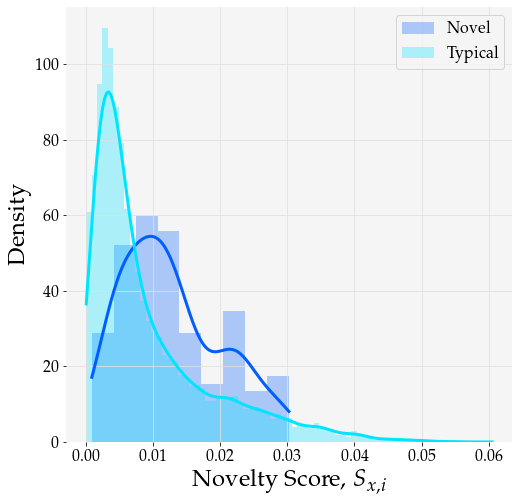

2021-05-24 14:44:06,780 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:06,781 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:06,781 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:06,781 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:06,781 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:06,782 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:06,782 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:06,782 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,782 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,783 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:06,810 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:06,810 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:06,811 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:06,811 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:06,811 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:06,812 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:06,812 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:06,812 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:06,812 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:06,813 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:06,843 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,844 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:06,844 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:06,844 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:06,847 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:06,848 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:06,848 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:06,848 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:06,849 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:06,849 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:06,875 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:06,875 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,876 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,877 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:06,878 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:06,878 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:06,879 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:06,879 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:06,879 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:06,879 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:06,905 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:06,905 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:06,905 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:06,905 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,906 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,906 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:06,906 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:44:06,907 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:06,909 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:06,909 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:06,940 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:06,941 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:06,941 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:06,941 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:06,941 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:06,942 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,942 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:06,943 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:06,943 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:06,943 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:07,065 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,065 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,066 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,066 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,067 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,067 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,067 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,067 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,068 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,068 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:07,113 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/491cca92ef7fc4f0496df6cd4270a1ae.dvi
2021-05-24 14:44:07,114 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,115 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,116 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,116 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,116 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,116 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,117 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,117 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,117 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:07,158 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,158 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,159 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,159 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,159 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,159 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,160 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,160 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,160 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:44:07,161 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:07,205 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,206 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,206 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,207 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:07,207 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,208 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,208 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,208 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,209 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,210 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:07,247 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,248 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,248 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,249 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-24 14:44:07,249 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,250 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,251 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,251 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,251 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,252 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:07,292 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,293 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,293 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,293 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,294 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,294 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:07,295 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,296 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,296 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,297 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:07,335 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,336 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,336 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,336 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,337 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,337 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,337 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,337 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/63ca6e0be05709794b698f3f5833e43e.dvi
2021-05-24 14:44:07,338 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,340 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:07,379 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,379 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,380 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,381 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,381 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,382 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,382 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,383 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,383 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,383 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:44:07,420 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,422 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,423 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,423 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,424 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,424 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,425 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,425 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,425 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,426 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 14:44:07,460 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,460 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,461 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,461 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,461 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-24 14:44:07,463 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,465 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,466 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,467 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,467 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:07,515 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,515 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,516 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,516 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,516 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,517 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,517 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,517 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,517 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,518 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 

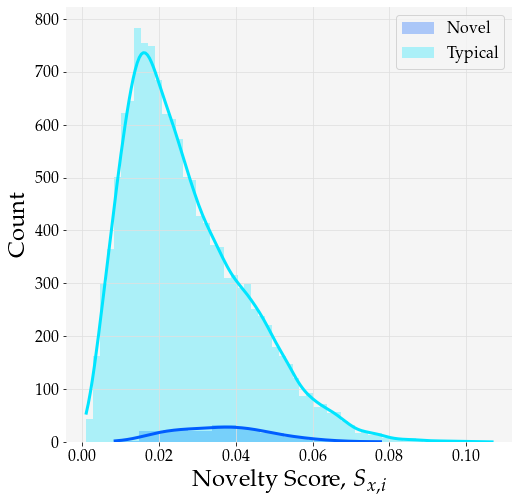

2021-05-24 14:44:07,737 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,738 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,738 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,739 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,739 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,740 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,740 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,741 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,742 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,743 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:07,781 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:07,782 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,782 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,783 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,783 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,783 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,783 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,784 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,785 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,785 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:07,828 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,828 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,829 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:07,830 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,833 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,834 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,834 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,835 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:07,835 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,835 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:07,869 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,869 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,870 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,870 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,870 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:07,871 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,871 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,872 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:07,873 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:07,873 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:07,911 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:07,911 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:07,911 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:07,912 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,912 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:07,912 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:07,913 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f3539b3bfa3a4196f2543c98727ec7f.dvi
2021-05-24 14:44:07,913 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:07,918 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:07,918 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:08,068 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,068 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,068 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,069 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,072 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,073 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,073 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,075 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,075 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:08,076 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:08,113 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,113 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,114 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,114 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,114 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,115 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,115 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,115 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,116 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,116 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:08,154 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:44:08,154 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,156 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,157 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,157 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,158 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,158 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,158 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,159 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,159 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:08,204 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,205 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,205 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:08,206 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,208 - DEBUG - Assigning font /b'F2' = b'pplri8r' (dvi)
2021-05-24 14:44:08,210 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,211 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,212 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,212 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,212 - DEBUG - Apple Chancery font is not compatible with us

2021-05-24 14:44:08,250 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,250 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,251 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,251 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,252 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,252 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:08,253 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,254 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,255 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,256 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:08,294 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,294 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,295 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,295 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,295 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,296 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,296 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,296 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f3539b3bfa3a4196f2543c98727ec7f.dvi
2021-05-24 14:44:08,298 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,301 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:08,351 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,351 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,352 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,352 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,352 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,353 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,355 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,356 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,356 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,357 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f3539b3bfa3a4196f2543c98727ec7f.dv

2021-05-24 14:44:08,400 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,400 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,400 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,401 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,401 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,401 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,405 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,406 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,406 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,407 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,407 - DEBUG - fam

2021-05-24 14:44:08,479 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,479 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,479 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,480 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,480 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,480 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,481 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,481 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,482 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,482 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dv

2021-05-24 14:44:08,519 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,522 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,523 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,523 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,524 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,525 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,526 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,526 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,527 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,527 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,527 - DEBUG - fam

2021-05-24 14:44:08,575 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,575 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,575 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:08,576 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,576 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,576 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,577 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:44:08,578 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,579 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,579 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:08,626 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,626 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:08,627 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,627 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,628 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,628 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,628 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,629 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,629 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,629 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:08,675 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,675 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f4292f9e067a55fc0b6fc029737cc33.dvi
2021-05-24 14:44:08,676 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,677 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,678 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,678 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,678 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,679 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,679 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,679 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:08,715 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,715 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:08,716 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,716 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:08,717 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,718 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,718 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,719 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,722 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,723 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:08,760 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:08,760 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f4292f9e067a55fc0b6fc029737cc33.dvi
2021-05-24 14:44:08,761 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:08,763 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:08,763 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:08,764 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:08,765 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:08,765 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:08,766 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:08,766 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:10,305 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,306 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,306 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,306 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,306 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,307 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:10,308 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,308 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,309 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,309 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:10,335 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,336 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,336 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,336 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,336 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,337 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,337 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,337 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/491cca92ef7fc4f0496df6cd4270a1ae.dvi
2021-05-24 14:44:10,338 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,339 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:10,366 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,366 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,367 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,367 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,368 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,368 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,368 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,369 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,369 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,369 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:10,399 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,401 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,402 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,402 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,402 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,402 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,403 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,403 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,404 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,404 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,404 - DEBUG - fam

2021-05-24 14:44:10,440 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,441 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,441 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,442 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,442 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,442 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,442 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,443 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,443 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,443 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,443 - DEBUG - fam

2021-05-24 14:44:10,478 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,478 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/11d3f079bac7ef456ad4fcfef7ec6c36.dvi
2021-05-24 14:44:10,479 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,480 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,480 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,481 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,481 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,481 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,481 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,482 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:10,522 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,522 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,523 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,523 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,523 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,524 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,524 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,524 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,524 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,525 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:10,566 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,567 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,567 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,567 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,567 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,568 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,569 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,569 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,569 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,570 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:10,607 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,608 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,608 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,609 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-24 14:44:10,610 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,613 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,613 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,613 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,614 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,614 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:10,663 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,663 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,663 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,664 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,665 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,665 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,665 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,665 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,666 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,666 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

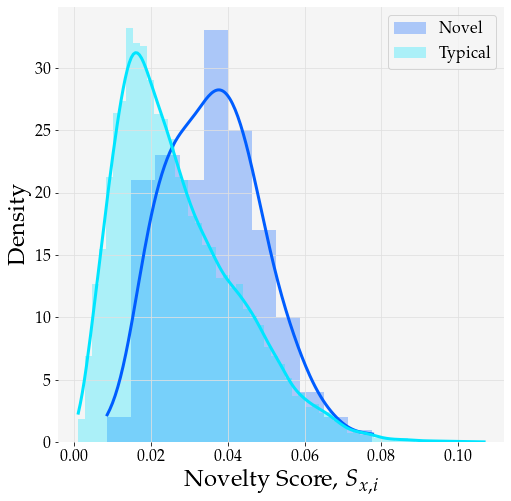

2021-05-24 14:44:10,839 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,841 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,841 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,842 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,843 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,843 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,843 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,844 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,844 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,844 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:10,880 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:10,882 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,883 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,883 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,883 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,884 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,886 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,887 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,887 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,887 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:10,926 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,926 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:10,927 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:10,928 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:10,928 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,929 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,929 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,930 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,930 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,930 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:10,967 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:10,967 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:10,968 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:10,968 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,969 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:10,969 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:10,970 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:10,970 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:10,973 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:10,974 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:11,009 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,009 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,010 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,010 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,011 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,011 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,011 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:11,012 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,013 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,013 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:11,049 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,049 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,050 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,050 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,051 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,051 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,052 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,052 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,052 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c2ad046775c699d06e76946f22922358.dvi
2021-05-24 14:44:11,053 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:11,095 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,095 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,096 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,096 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,096 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,096 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,097 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,098 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,098 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,098 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:11,132 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,133 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,133 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,134 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,134 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,134 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,138 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,140 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,141 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,142 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,142 - DEBUG - fam

2021-05-24 14:44:11,189 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,189 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,189 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,189 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,190 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,190 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,191 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,191 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,191 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,192 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dv

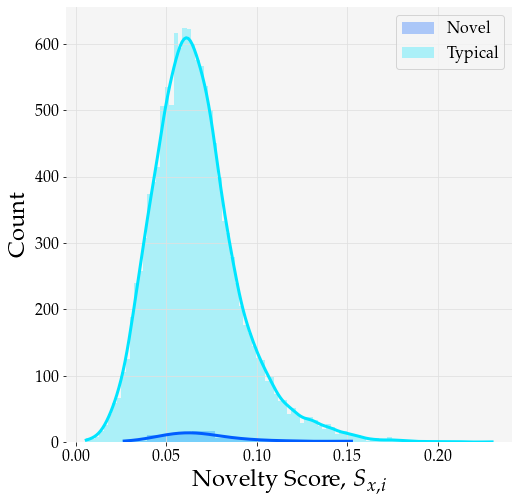

2021-05-24 14:44:11,487 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,488 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,488 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,489 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,489 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,489 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,490 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,490 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,491 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,491 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:11,525 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:11,526 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,526 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,527 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,527 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,528 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,528 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,528 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,528 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,529 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:11,570 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,570 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,571 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:44:11,571 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,572 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,573 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,573 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,573 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,574 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,574 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:11,610 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,611 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,611 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,611 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,612 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:11,612 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,613 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,613 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,613 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,613 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:11,653 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,655 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,655 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,656 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,656 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,657 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,657 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:44:11,658 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,794 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,794 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:11,833 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,833 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,833 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,834 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,837 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,838 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,838 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,838 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,839 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:11,839 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:11,876 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,878 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,879 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,880 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,880 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,881 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,881 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,881 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:11,881 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,882 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,882 - DEBUG - fam

2021-05-24 14:44:11,922 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,923 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:44:11,925 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,926 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,926 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,926 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,927 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,927 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:11,927 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:11,927 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:11,964 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,965 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:11,967 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:11,970 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:11,970 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:11,971 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:11,971 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:11,972 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:11,972 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:11,973 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:12,012 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,012 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,013 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,013 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,014 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,014 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:12,015 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,016 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,016 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:12,016 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:12,072 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:12,074 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,074 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,074 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,075 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,075 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,076 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,076 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:44:12,077 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,079 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:12,151 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,151 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,151 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,152 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,152 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,152 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,153 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:12,154 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,154 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,155 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:12,191 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,191 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,192 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,192 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,195 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,196 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,196 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:44:12,196 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,198 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,199 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:12,235 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,236 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,236 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:12,236 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:12,236 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:12,237 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,237 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,237 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,239 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,240 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:12,280 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,282 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,283 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:12,283 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:12,284 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:12,286 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,287 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,287 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,288 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,288 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,288 - DEBUG - fam

2021-05-24 14:44:12,331 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,331 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:12,333 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,333 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,334 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:12,334 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:12,334 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:12,334 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,335 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,335 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:12,373 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:12,373 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:12,374 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:12,374 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:12,374 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:12,375 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,376 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,376 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,376 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,377 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 14:44:12,416 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:12,416 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,417 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:12,418 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:12,418 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-24 14:44:12,419 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:12,421 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:12,422 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:12,422 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:12,423 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:13,585 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,586 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:13,586 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,586 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,586 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,587 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:44:13,587 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:13,589 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:13,589 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,589 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:13,616 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,617 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,617 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,617 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:13,617 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,618 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:13,618 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:13,618 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:13,618 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,619 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:44:13,660 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,660 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:44:13,661 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:13,662 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:13,663 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,663 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:13,663 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:13,664 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:13,664 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,664 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:13,705 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,706 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:13,707 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:13,707 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:13,707 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,708 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:13,708 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:13,708 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:13,709 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,709 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:13,740 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,740 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,740 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,741 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:13,742 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:13,744 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:13,745 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,745 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:13,745 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:13,746 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:13,772 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,772 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:13,772 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,773 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,773 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,773 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:13,773 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:13,775 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:13,775 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,775 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:13,806 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:13,808 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:13,809 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,809 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:13,810 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,810 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,811 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,811 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:44:13,812 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:13,813 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:13,970 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:13,971 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:13,971 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:13,971 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:13,972 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:13,972 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:13,974 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,974 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:13,974 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:13,975 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dv

2021-05-24 14:44:14,024 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,024 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,025 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,025 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,025 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,026 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,026 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,026 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,027 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,027 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dv

2021-05-24 14:44:14,072 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,073 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,073 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,073 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,074 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,074 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,074 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,074 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,076 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,076 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:14,117 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,117 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,118 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-24 14:44:14,118 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,119 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,120 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,120 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,121 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,121 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,121 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:14,161 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,161 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,161 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,162 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,162 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:14,163 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,163 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,164 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,164 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,165 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:14,210 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3e4df96a5b1dc6517618bc22f9ba990c.dvi
2021-05-24 14:44:14,210 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,212 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,212 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,212 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,213 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,213 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,213 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,214 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,214 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:14,256 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,256 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,257 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,257 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,257 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,257 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,258 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,258 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,258 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-24 14:44:14,259 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:14,316 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,316 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,317 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,317 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,318 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,318 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,318 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,318 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,319 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,319 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 

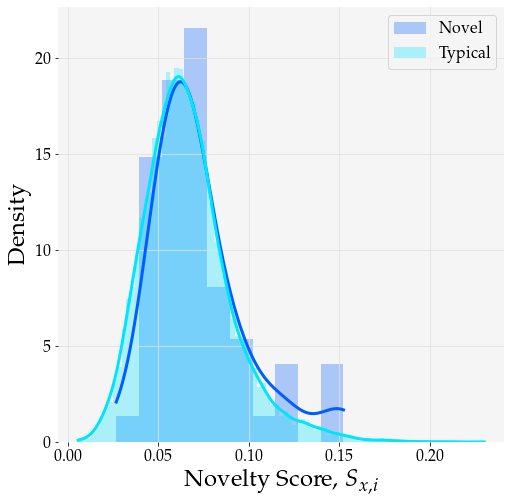

2021-05-24 14:44:14,471 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,472 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,472 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,472 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,473 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,473 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,473 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,473 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,474 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,475 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:14,524 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:14,525 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,526 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,526 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,526 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,527 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,527 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,527 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,528 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,528 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:14,567 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/104f0c66aaa256b37474b9ca7b53baca.dvi
2021-05-24 14:44:14,568 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,570 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,570 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,571 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,571 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,571 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,572 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,572 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,572 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:14,611 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,612 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,613 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,613 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,613 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,614 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,614 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/82bf971d84f8c5eb6c953fd2acfaa7fd.dvi
2021-05-24 14:44:14,615 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,616 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,617 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:14,659 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,660 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,660 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,661 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:14,661 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,662 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,662 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,662 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,663 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,663 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:14,706 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,706 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,707 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,707 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,707 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,707 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-24 14:44:14,708 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,709 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,710 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,710 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:14,753 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,753 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,754 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,754 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,754 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,754 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,755 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,755 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:14,756 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,757 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:14,793 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,794 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,794 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,794 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,795 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,795 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-24 14:44:14,796 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,797 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,798 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,798 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:14,841 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,841 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:14,841 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:14,841 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:14,842 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,842 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,842 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,843 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,843 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,843 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:14,884 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,884 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,885 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,885 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,885 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,885 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,886 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:14,887 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,888 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,888 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:14,925 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:14,925 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:14,925 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:14,926 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,926 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:14,926 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:14,927 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-24 14:44:14,928 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:14,943 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:14,944 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

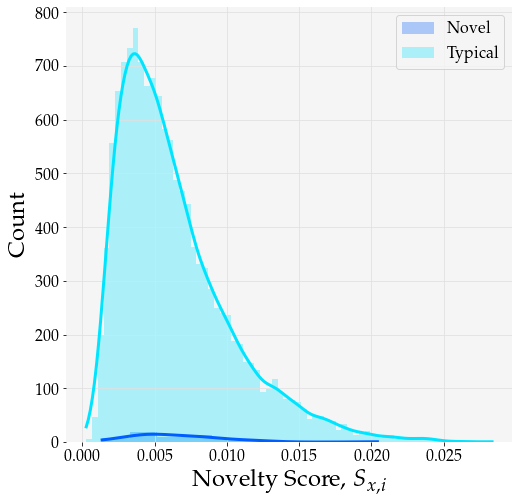

2021-05-24 14:44:15,167 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,167 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,168 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,168 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,168 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,169 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,169 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,169 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,170 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,170 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:15,212 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:15,213 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,213 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,214 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,214 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,215 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,215 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,217 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,217 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,218 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:15,256 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,256 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,257 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:15,258 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,262 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,263 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,263 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,263 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,264 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,264 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:15,303 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,303 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,304 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,305 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,305 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:15,306 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,307 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,308 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,309 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,310 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:15,347 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,347 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,347 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,347 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,348 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,348 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,350 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/dda7872d8eaf9ddfc94899c31e4bb29a.dvi
2021-05-24 14:44:15,350 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,351 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,352 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:15,397 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,397 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,398 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,398 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,399 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,399 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,399 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,400 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,403 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:15,403 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:15,557 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,557 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,557 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,558 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,558 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,558 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,558 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,559 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,559 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,559 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:15,593 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/82bf971d84f8c5eb6c953fd2acfaa7fd.dvi
2021-05-24 14:44:15,595 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,596 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,596 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,597 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,597 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,597 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,598 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,599 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,599 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:15,644 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,644 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,644 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,644 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/82bf971d84f8c5eb6c953fd2acfaa7fd.dvi
2021-05-24 14:44:15,646 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,647 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,648 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,648 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,649 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,649 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:15,692 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,692 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,692 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,693 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,693 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,693 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,693 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:15,695 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:15,695 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,696 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:15,734 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,735 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,735 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,736 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,736 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,736 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,737 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,737 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:15,738 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9a1cd5f6f69715f9ab1f4e024d553a53.dvi
2021-05-24 14:44:15,738 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:15,776 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:15,777 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:15,777 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:15,778 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:15,778 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:15,778 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:15,779 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:15,779 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,779 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:15,780 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:17,124 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,125 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,125 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,125 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,125 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,126 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,126 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,126 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,126 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,127 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dv

2021-05-24 14:44:17,156 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,157 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,157 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,157 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,157 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,157 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,158 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,158 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,158 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,159 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dv

2021-05-24 14:44:17,185 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,186 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,186 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,186 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,187 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,187 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,187 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,187 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,188 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,188 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,188 - DEBUG - fam

2021-05-24 14:44:17,215 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,215 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,215 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,215 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,216 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,216 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,217 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,221 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,221 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,222 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dv

2021-05-24 14:44:17,258 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,258 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,258 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,258 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,259 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,259 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,259 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,260 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,260 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,260 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:17,299 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-24 14:44:17,300 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,302 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,302 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,303 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,303 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,303 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,304 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,304 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,304 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:17,362 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,362 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,363 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,363 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,364 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,365 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,366 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,366 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,366 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,367 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:17,418 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/46de17df7d48b7418e4a03283110f16c.dvi
2021-05-24 14:44:17,418 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,420 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,420 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,421 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,421 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,422 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,422 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,423 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,423 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:17,469 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,469 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,470 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:44:17,470 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,471 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,471 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,472 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,472 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,472 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,473 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:17,510 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,510 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,511 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,511 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,512 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d7f16887d1c83bd1259c35f91cc6aca3.dvi
2021-05-24 14:44:17,515 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,516 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,517 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,517 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,517 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:17,553 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,553 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,553 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,554 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,554 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,554 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,556 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:17,557 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,557 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,558 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:17,594 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,595 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,595 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,595 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,595 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,596 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,596 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,596 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,597 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-24 14:44:17,598 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:17,741 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,742 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,742 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,743 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,743 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,744 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,744 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,744 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,744 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,745 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:17,787 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:17,788 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,789 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,789 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,789 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,789 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,790 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,790 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,790 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,791 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:17,831 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,832 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,832 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,833 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,834 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:17,834 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,834 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,835 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,835 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,835 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:17,869 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,869 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,870 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,870 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b4210e3ee9381975076c84e537ee4edd.dvi
2021-05-24 14:44:17,871 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,874 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,874 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,875 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,875 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,875 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:17,919 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,919 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,919 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,921 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:17,921 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,922 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,922 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,923 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:17,923 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:17,923 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:17,957 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:17,958 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:17,958 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,958 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:17,958 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:17,959 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9a1cd5f6f69715f9ab1f4e024d553a53.dvi
2021-05-24 14:44:17,960 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:17,961 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:17,961 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:17,961 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:44:18,002 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,002 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,005 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,006 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,006 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,006 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,007 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,007 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:18,007 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,008 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:44:18,058 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,058 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,059 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,059 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d7f16887d1c83bd1259c35f91cc6aca3.dvi
2021-05-24 14:44:18,060 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,061 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,061 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,062 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,062 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,063 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:18,096 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,096 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,097 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,097 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,097 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,098 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,098 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,099 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,100 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,100 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/dda7872d8eaf9ddfc94899c31e4bb29a.dv

2021-05-24 14:44:18,145 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,148 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,149 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,151 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,151 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,151 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,152 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,152 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,152 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,152 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:18,204 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,205 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,205 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,206 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-24 14:44:18,207 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,209 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,209 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,210 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,210 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,210 - DEBUG - Apple Chancery font is not compat

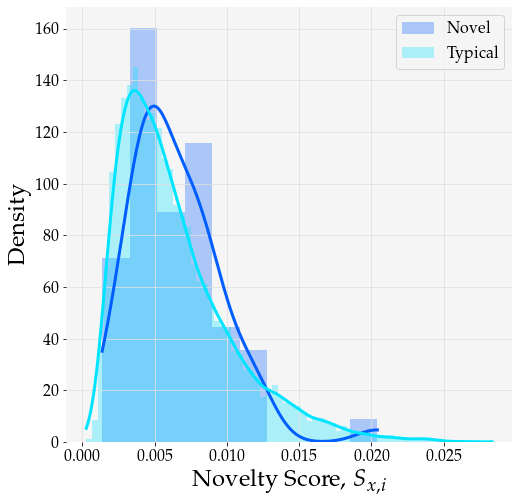

2021-05-24 14:44:18,250 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,250 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,250 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,251 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,251 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,251 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,252 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,252 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,252 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,253 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:18,286 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:18,287 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,288 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,288 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,288 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,288 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,289 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,289 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,289 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,290 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:44:18,330 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,330 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,330 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:44:18,331 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,334 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,335 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,335 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,336 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,336 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,336 - DEBUG - Textile font is not compatible with

2021-05-24 14:44:18,378 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,378 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,379 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,379 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,380 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:18,380 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,381 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,382 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,382 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,382 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:44:18,422 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,422 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,423 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,423 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,423 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,424 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,424 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-24 14:44:18,425 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,430 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,430 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:44:18,580 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,580 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,581 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,582 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,582 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,582 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,583 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,583 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,583 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:18,584 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:44:18,620 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,620 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,621 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,621 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,621 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,622 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,622 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,622 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,622 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,624 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:18,659 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,660 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,660 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,660 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,661 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,661 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,661 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,661 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,662 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,665 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:44:18,702 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,702 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,703 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,703 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/491cca92ef7fc4f0496df6cd4270a1ae.dvi
2021-05-24 14:44:18,705 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,706 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,707 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,707 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,707 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,707 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:18,747 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,747 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:44:18,748 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,749 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,749 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,749 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,750 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,751 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,751 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,751 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:44:18,790 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,791 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,791 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,792 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-24 14:44:18,793 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,794 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,795 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,797 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,797 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,797 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:44:18,837 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,837 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,837 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,838 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,838 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,838 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,841 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,842 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,842 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,842 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 

2021-05-24 14:44:18,878 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,881 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,881 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:44:18,881 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:44:18,882 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:44:18,882 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,884 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,885 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,886 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,888 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,888 - DEBUG - fam

2021-05-24 14:44:18,927 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:44:18,927 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:44:18,928 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:44:18,928 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,929 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:44:18,933 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:44:18,933 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-24 14:44:18,934 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:44:18,935 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:44:18,935 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

In [56]:
plt.style.use('../../utils/_extras/primary.mplstyle')

# View distibution of IoUs for typical and novel samples
for sn, res in iou_results.items():
    
    labels = res['labels'].astype(bool)
    
    plt.figure(figsize=(8, 8))
    sns.histplot(data=res['scores'][labels], color='C5', alpha=0.3,  stat='count', lw=0, 
                 fill=True, kde=True, label='Novel')
    sns.histplot(data=res['scores'][~labels], color='C2', alpha=0.3, stat='count', lw=0, 
                 fill=True, kde=True, label='Typical')
    plt.xlabel('Novelty Score, $S_{x,i}$')
    plt.legend()
    plt.savefig(f'score-distributions/LunarAnalogueRP-ReconsScoreCount-{sn}.pdf', bbox_inches='tight')
    plt.show()
        
    plt.figure(figsize=(8, 8))
    sns.histplot(data=res['scores'][labels], color='C5', alpha=0.3,  stat='density', lw=0, 
                 fill=True, kde=True, label='Novel')
    sns.histplot(data=res['scores'][~labels], color='C2', alpha=0.3, stat='density', lw=0, 
                 fill=True, kde=True, label='Typical')
    plt.xlabel('Novelty Score, $S_{x,i}$')
    plt.legend()
    plt.savefig(f'score-distributions/LunarAnalogueRP-ReconsScoreDensity-{sn}.pdf', bbox_inches='tight')

2021-05-24 14:19:03,316 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,317 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,317 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,317 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,317 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,318 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,318 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,318 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,318 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,319 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:03,349 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:03,350 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,350 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,351 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,351 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,352 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,352 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,352 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,353 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,353 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:03,402 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,403 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,403 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:03,405 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,408 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,408 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,408 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,409 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,409 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,409 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:03,451 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,452 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,452 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,452 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,454 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:03,454 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,455 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,455 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,455 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,456 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

SimpleVAE-nre1 1120


2021-05-24 14:19:03,460 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,460 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,460 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,461 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,461 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,462 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,462 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,462 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,463 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,463 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:03,575 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,575 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:03,576 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,577 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,577 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,577 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,578 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,578 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,578 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,578 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:19:03,622 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,622 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,622 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,622 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:19:03,624 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,625 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,625 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,625 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,626 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,627 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:03,664 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,665 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,665 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,665 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,666 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,666 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:03,668 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,668 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,669 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,669 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:03,866 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:03,866 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,867 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,867 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,868 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,868 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,868 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,868 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,869 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,869 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:03,896 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,896 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,896 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 14:19:03,896 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,898 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,899 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,899 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:03,899 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,900 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,900 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:03,938 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,938 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,939 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,939 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,939 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,939 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/317723e16c5acef4be457dfd218d3063.dvi
2021-05-24 14:19:03,940 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,942 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:03,943 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:03,943 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:03,979 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:03,980 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:03,980 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:03,980 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:03,980 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,981 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:03,981 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:03,981 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:03,983 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:03,984 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:19:04,021 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,022 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,022 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,023 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,023 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,024 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,025 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,025 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,025 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,026 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dv

2021-05-24 14:19:04,075 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,076 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,077 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,077 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,078 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,078 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,078 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,079 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,079 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,079 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,080 - DEBUG - fam

2021-05-24 14:19:04,171 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,172 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,172 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,173 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,173 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,174 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:04,174 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,175 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,176 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,176 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:04,207 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,207 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,207 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,208 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:04,208 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,209 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,209 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,209 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,210 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,210 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:04,244 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,244 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,245 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,245 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,245 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,245 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50b063103f9808b81526cf7a814e0d24.dvi
2021-05-24 14:19:04,246 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,247 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,248 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,248 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:04,279 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,280 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,280 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,280 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,280 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,281 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,282 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,282 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,282 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,283 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:04,317 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,320 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,321 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,321 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,322 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,322 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,323 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,323 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,323 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,324 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,324 - DEBUG - fam

<Figure size 576x576 with 0 Axes>

2021-05-24 14:19:04,407 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:04,417 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:04,439 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:04,448 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:04,490 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:04,498 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:04,511 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,512 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,512 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,512 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,513 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-0

2021-05-24 14:19:04,542 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,542 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,542 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,542 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,543 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,543 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:04,544 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,544 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,545 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,545 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:04,573 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:04,574 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,576 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,576 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,577 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,577 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,577 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,577 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,578 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,578 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:04,609 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,609 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,609 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,610 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,610 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,610 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,610 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,611 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,611 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,611 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:04,642 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50b063103f9808b81526cf7a814e0d24.dvi
2021-05-24 14:19:04,642 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,643 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,644 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,645 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,645 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,645 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,645 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,646 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,646 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:04,683 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,683 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,684 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,684 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,685 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,686 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,686 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,686 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,687 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,687 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:04,725 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,725 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,725 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,726 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,726 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,726 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,727 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,727 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,727 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,729 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

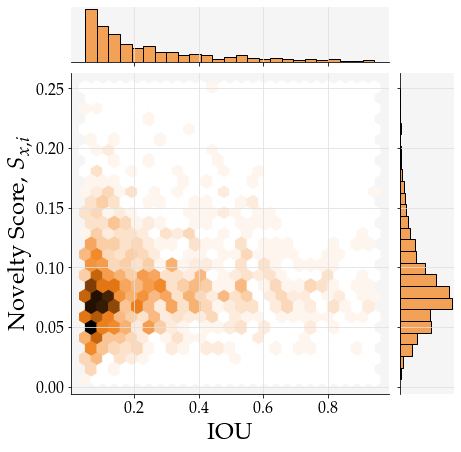

2021-05-24 14:19:04,900 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,900 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,901 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,902 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,902 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,902 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,903 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,903 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,903 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,903 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:04,944 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:04,945 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,946 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,946 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,946 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,947 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,947 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,947 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:04,948 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:04,948 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:04,991 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:04,991 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:04,992 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:04,993 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:04,994 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:04,994 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:04,994 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:04,995 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:04,995 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:04,996 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:05,036 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,036 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,036 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,036 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,037 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:05,038 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,038 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')


SimpleVAE-nre2 1120


2021-05-24 14:19:05,039 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,039 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,039 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:05,039 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,040 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:05,040 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,040 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,041 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,041 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,041 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dv

2021-05-24 14:19:05,147 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:19:05,151 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,152 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,153 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,153 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,153 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:05,154 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,154 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:05,154 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,154 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:05,193 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,193 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,194 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:05,194 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,196 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,197 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,198 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,198 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:05,198 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,199 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:05,233 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,234 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,235 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,236 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,236 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50b063103f9808b81526cf7a814e0d24.dvi
2021-05-24 14:19:05,237 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,238 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,238 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,238 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,239 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:19:05,423 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,424 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,424 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,424 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,425 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:05,425 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,425 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:05,425 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,426 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,426 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,426 - DEBUG - fam

2021-05-24 14:19:05,458 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,458 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d57805ca30df78f885241e6b3aa903c5.dvi
2021-05-24 14:19:05,459 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,460 - DEBUG - Assigning font /b'F1' = b'pplr8r' (dvi)
2021-05-24 14:19:05,461 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,462 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,462 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,462 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:05,462 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,463 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 1

2021-05-24 14:19:05,495 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,495 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,495 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,496 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,496 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:05,497 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,498 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,499 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:05,499 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,499 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:19:05,530 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,530 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:05,530 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,533 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,534 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,534 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,535 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50b063103f9808b81526cf7a814e0d24.dvi
2021-05-24 14:19:05,536 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:05,537 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:05,537 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:19:05,580 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:05,581 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:05,581 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:05,584 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:05,584 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:05,586 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,587 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:05,588 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:05,588 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/efec8296de9918f3450d8d95431443de.dvi
2021-05-24 14:19:05,589 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:19:06,852 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/371b2ad568146a968cf5fde2df359eac.dvi
2021-05-24 14:19:06,853 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:06,854 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:06,856 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:06,856 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:06,856 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:06,856 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:06,857 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:06,857 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:06,857 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:06,887 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:06,887 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:06,887 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:06,888 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:06,888 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:06,889 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:06,889 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:06,889 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:06,890 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:06,890 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:06,929 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:06,929 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:06,929 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:06,930 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:06,930 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/371b2ad568146a968cf5fde2df359eac.dvi
2021-05-24 14:19:06,931 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:06,933 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:06,933 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:06,933 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:06,934 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:19:06,981 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:06,981 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:06,981 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:06,982 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:06,982 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:06,982 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:06,982 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:19:06,985 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:06,987 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:06,989 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:19:07,091 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,093 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,093 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,094 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,095 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,095 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,096 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,096 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,096 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,096 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:07,130 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,130 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,131 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,131 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,132 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,132 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,132 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,133 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,133 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,133 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:07,173 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:07,174 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,174 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,175 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,177 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,179 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,180 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,180 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,180 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,181 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:07,219 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,220 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,220 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/092b3f9bfe5f72949069d1b48e96c2bb.dvi
2021-05-24 14:19:07,221 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,222 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,222 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,223 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,223 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,223 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,223 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:07,267 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,267 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,268 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,268 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,268 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,268 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,269 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,269 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,270 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,270 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:07,313 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,314 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,314 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,314 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,314 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,315 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,315 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,315 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,316 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,316 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:07,353 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,353 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/616caca65bc027bca7ea66a4bbd51c3c.dvi
2021-05-24 14:19:07,354 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,356 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,357 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,357 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,357 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,360 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,361 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,361 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

<Figure size 576x576 with 0 Axes>

2021-05-24 14:19:07,420 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,420 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,420 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,421 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,421 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,421 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,421 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,422 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,423 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,424 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:07,466 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:07,466 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,467 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,472 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,472 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,473 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,473 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,473 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,473 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,474 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:07,629 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,629 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,630 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,630 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,630 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,632 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,632 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,632 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:07,633 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,634 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:19:07,671 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,671 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,671 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,671 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,672 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,672 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,672 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,673 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,673 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,673 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:07,712 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/317723e16c5acef4be457dfd218d3063.dvi
2021-05-24 14:19:07,715 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,717 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,717 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,717 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,718 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,718 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,718 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,719 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,719 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:07,761 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,761 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,762 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:07,763 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,764 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,764 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,764 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,764 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,765 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,765 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:07,799 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,800 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,800 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,801 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,801 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/092b3f9bfe5f72949069d1b48e96c2bb.dvi
2021-05-24 14:19:07,802 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,803 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,804 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,804 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,804 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:19:07,837 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,838 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,838 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,839 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,840 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,841 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,841 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,842 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,842 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,842 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:07,888 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,888 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,889 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,889 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,889 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:07,890 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:07,890 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:07,890 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,891 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,891 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:07,940 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,940 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:07,941 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:07,941 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/616caca65bc027bca7ea66a4bbd51c3c.dvi
2021-05-24 14:19:07,942 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:07,944 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:07,945 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:07,946 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:07,946 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:07,947 - DEBUG - Apple Chancery font is not compat

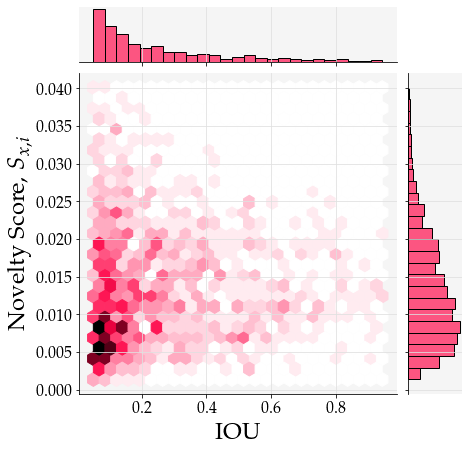

2021-05-24 14:19:08,109 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,109 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,110 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,110 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,110 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,111 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,111 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,111 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,111 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,112 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:08,151 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:08,151 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,152 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,152 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,153 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,153 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,153 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,154 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,154 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,154 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:08,197 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,197 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,201 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:08,201 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,202 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,203 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,203 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,203 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,203 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,204 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:08,245 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,245 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,246 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,246 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,246 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:08,247 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,248 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,248 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,249 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,249 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

CompressionCAEHighCapacity-nre1 1120


2021-05-24 14:19:08,255 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,255 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,255 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,256 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,256 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,256 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,257 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:08,258 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,258 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,259 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:19:08,441 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,441 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,441 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,442 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,442 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,442 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,442 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,443 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,443 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,443 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:08,483 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:19:08,483 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,485 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,485 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,485 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,486 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,486 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,486 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,487 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,487 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:08,522 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,522 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,523 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:08,524 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,527 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,528 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,528 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,528 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,529 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,530 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:08,717 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,717 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,718 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,718 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,718 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,718 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,719 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,719 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,719 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,719 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:08,752 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:19:08,753 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,755 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,755 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,755 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,755 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,756 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,756 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,756 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,756 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:08,790 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,790 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,791 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:19:08,791 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,793 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,793 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,793 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,793 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,794 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,794 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:08,824 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,824 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,826 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,827 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,828 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:08,828 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,829 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,829 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,830 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,830 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:19:08,874 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,874 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:08,875 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:08,878 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,879 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,879 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,880 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:19:08,880 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,881 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,881 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:19:08,979 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:08,979 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:08,979 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:19:08,980 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:08,981 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:08,982 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:08,982 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:08,982 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:08,982 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:08,983 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:09,012 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:09,012 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:09,012 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:09,012 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:09,013 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:09,013 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:09,013 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:09,013 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:09,014 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:09,014 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:09,048 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:19:09,049 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:09,050 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:09,051 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:09,051 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:09,051 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:09,051 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:09,052 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:09,052 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:09,052 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:09,087 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:09,088 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:09,088 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:09,088 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:09,089 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:09,089 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:09,089 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:09,089 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:09,090 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:09,090 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:10,265 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,265 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,265 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,265 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,266 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,266 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,266 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,266 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,267 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,267 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:10,298 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,298 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,300 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:19:10,300 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:10,301 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,302 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,302 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,302 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,302 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,303 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:10,341 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,341 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,341 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,341 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,342 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:10,343 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:10,343 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,343 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,344 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,344 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

2021-05-24 14:19:10,386 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:19:10,387 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:10,390 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,391 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,392 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,392 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,393 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,393 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,393 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,394 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:10,435 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,436 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,436 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,437 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,437 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,438 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,438 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,439 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,439 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:19:10,440 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

<Figure size 576x576 with 0 Axes>

2021-05-24 14:19:10,486 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:10,496 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:10,518 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:10,529 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:10,569 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:10,577 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:10,591 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,591 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,592 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,592 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,592 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-0

2021-05-24 14:19:10,620 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,620 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,621 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,621 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,621 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,621 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:10,622 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:10,623 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,623 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,624 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:10,652 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:10,653 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:10,654 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,655 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,655 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,655 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,656 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,656 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,656 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,656 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:10,691 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,691 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,692 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,692 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,692 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,693 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,693 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,693 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,694 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,694 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:10,742 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-24 14:19:10,743 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:10,744 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,744 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,745 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,745 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,745 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,746 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,746 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,746 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:10,790 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,790 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,791 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,791 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,791 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,791 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,792 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,792 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,792 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:19:10,795 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:19:10,840 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,840 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,840 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,841 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,841 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,841 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:10,842 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,843 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,843 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,844 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

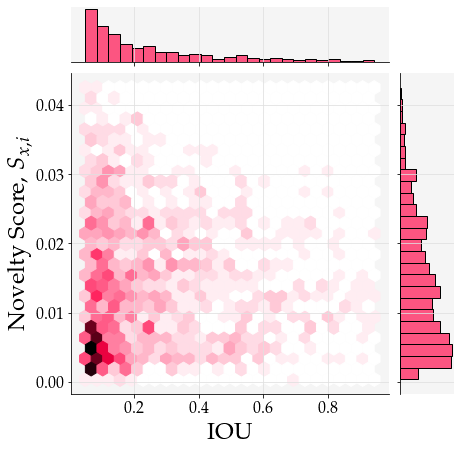

2021-05-24 14:19:10,979 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:10,980 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:10,980 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:10,981 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:10,981 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:10,981 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:10,982 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:10,982 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,982 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:10,982 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:11,011 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:11,012 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,012 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,013 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,013 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,013 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,014 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,014 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,014 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,015 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:11,056 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,057 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,057 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:11,058 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,059 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,059 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,059 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,060 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,060 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,060 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:11,092 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,092 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,092 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,093 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,093 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:11,094 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,095 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,096 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,097 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,098 - DEBUG - family: sans-serif, font: Computer Modern Sans Se

BaselineAAE-nre1 1120


2021-05-24 14:19:11,126 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:11,134 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:11,191 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,191 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,191 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,192 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,192 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,193 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,193 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,193 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,193 - DEBUG - Bitstream Vera Sans Mono font i

2021-05-24 14:19:11,235 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,235 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:11,236 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,237 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,237 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,237 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,238 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,239 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,239 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,240 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:19:11,282 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,282 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,283 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,283 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:19:11,286 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,287 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,288 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,288 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,289 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,289 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:11,331 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,331 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,331 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,332 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,332 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,332 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:19:11,333 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,333 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,334 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,334 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:11,518 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:11,519 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,519 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,520 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,520 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,521 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,521 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,521 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,521 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,522 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:11,557 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,557 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,558 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,558 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/35fc8a5d7b792fb5dcda0900f8005783.dvi
2021-05-24 14:19:11,559 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,561 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,561 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,561 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,562 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,562 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:11,594 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,595 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,595 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,595 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,596 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,597 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-24 14:19:11,598 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,599 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,599 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,599 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:11,646 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,646 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,647 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,647 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,648 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,648 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,649 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,649 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-24 14:19:11,650 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,652 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:19:11,698 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,699 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,699 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,699 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,699 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,700 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,701 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,703 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,704 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,704 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dv

2021-05-24 14:19:11,794 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,795 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,795 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,795 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:11,796 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,798 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,798 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,798 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,799 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,799 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:11,830 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,830 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:11,831 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,832 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,832 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,832 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,833 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,833 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,833 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,834 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:19:11,869 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,870 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,870 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,872 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:19:11,872 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:11,873 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,874 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,874 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,874 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,875 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:11,919 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,920 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:11,920 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,921 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,922 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,922 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,922 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,923 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,923 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,923 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:11,966 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:11,966 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:11,966 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:11,968 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:11,968 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:11,968 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:11,969 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,969 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:11,969 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:11,970 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

<Figure size 576x576 with 0 Axes>

2021-05-24 14:19:12,019 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:12,029 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:12,051 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:12,061 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:12,099 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:12,107 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:12,121 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,121 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,122 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,122 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,122 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-0

2021-05-24 14:19:12,157 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,157 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,157 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,157 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,158 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:12,158 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:12,159 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:12,159 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,160 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,160 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:12,190 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:12,191 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:12,192 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,192 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,192 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,193 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,193 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,193 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,194 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,194 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:12,233 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,233 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,233 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,234 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,234 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,235 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,235 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,235 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,236 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,236 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:12,276 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-24 14:19:12,276 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:12,277 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,278 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,278 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,278 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,279 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,279 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,279 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,280 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:12,321 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,321 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,321 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,322 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,322 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,322 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,323 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,323 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:12,323 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-24 14:19:12,324 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:19:12,364 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,365 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,365 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,365 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,366 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,366 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:12,367 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,367 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,368 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,368 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

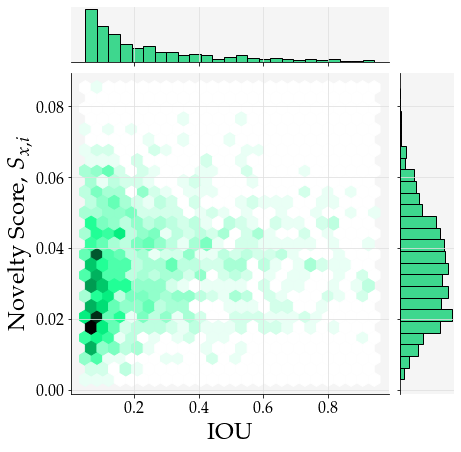

2021-05-24 14:19:12,507 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,507 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,507 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,508 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,508 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,508 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,508 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,509 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,509 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,510 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:12,554 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:12,555 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:12,556 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,556 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,556 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,557 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,557 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,557 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:12,557 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:12,558 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:12,599 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:12,600 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:12,603 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:12,604 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:12,605 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:12,606 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:12,607 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:12,607 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:12,607 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:12,608 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:13,696 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:13,696 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:13,697 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,697 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:13,697 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,698 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,698 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,698 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,698 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,699 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:13,726 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,726 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:13,726 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,727 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,727 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,727 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,728 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,728 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,728 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:19:13,728 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:19:13,761 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,762 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,762 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,762 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,762 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,763 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,763 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:13,764 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:13,764 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,764 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:13,798 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,799 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,799 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,799 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,800 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,800 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,800 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/eda4fabf79b03b187976665ed85acc11.dvi
2021-05-24 14:19:13,800 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:13,802 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:13,802 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:19:13,846 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,846 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:13,846 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,847 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,847 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,847 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,847 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,848 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,848 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:13,849 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:19:13,884 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,885 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:13,885 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,885 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,886 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,886 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,886 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,886 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,887 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/104f0c66aaa256b37474b9ca7b53baca.dvi
2021-05-24 14:19:13,888 - DEBUG - Dvi._xxx: encountered special: papersize=5203.

2021-05-24 14:19:13,931 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,931 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,932 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,932 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:13,932 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:13,933 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,933 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:13,933 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,933 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,934 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:19:13,973 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:13,974 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:13,975 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:13,975 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:13,976 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:13,976 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:13,978 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,978 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:13,979 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:13,979 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

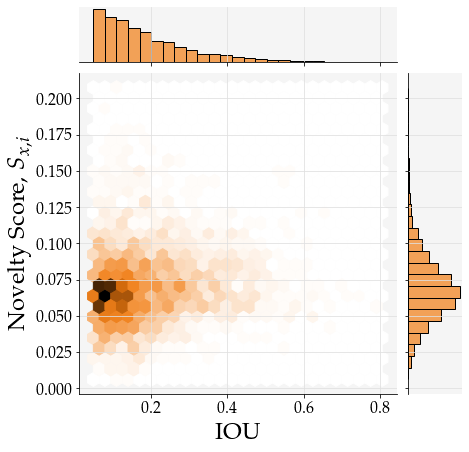

2021-05-24 14:19:14,159 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,160 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,160 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,160 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,161 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,161 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,161 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,162 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,162 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,162 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:14,197 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:14,197 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,198 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,198 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,199 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,199 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,200 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,200 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,201 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,202 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:14,249 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,250 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,250 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:14,251 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,253 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,253 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,253 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,254 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,254 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,254 - DEBUG - Textile font is not compatible with

BaselineCAE-bing1 2811


2021-05-24 14:19:14,299 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,299 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,299 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,299 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,300 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,300 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,300 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:14,301 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,303 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,303 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

2021-05-24 14:19:14,417 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,418 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,418 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,418 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,418 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,419 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,419 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,419 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,419 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,420 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:14,454 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/317723e16c5acef4be457dfd218d3063.dvi
2021-05-24 14:19:14,455 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,459 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,460 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,460 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,460 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,461 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,461 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,461 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,461 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:14,494 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,494 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,495 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:14,496 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,496 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,496 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,497 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,497 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,497 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,497 - DEBUG - Textile font is not compatible with

2021-05-24 14:19:14,535 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,535 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,535 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,535 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,536 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:19:14,537 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,540 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:14,551 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:14,572 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:14,582 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:14,623 

2021-05-24 14:19:14,738 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,739 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,739 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,739 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,739 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,740 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,740 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,740 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,740 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,741 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,741 - DEBUG - fam

2021-05-24 14:19:14,786 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,786 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:19:14,787 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,788 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,788 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,789 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,789 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,789 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,789 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,790 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:19:14,829 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,830 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,830 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,830 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:14,831 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,833 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,833 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,833 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:14,834 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,834 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:14,871 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,872 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,872 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,872 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,872 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,873 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b4210e3ee9381975076c84e537ee4edd.dvi
2021-05-24 14:19:14,874 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,876 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:14,876 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:14,876 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:14,914 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:14,914 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:14,915 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:14,915 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:14,916 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,916 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:14,916 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:14,917 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-24 14:19:14,918 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:14,918 - DEBUG - family: serif, font: Palatino, info

2021-05-24 14:19:15,013 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,013 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,014 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,014 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/da12be043bf66fa494ffe6a28495e74d.dvi
2021-05-24 14:19:15,015 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,016 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,018 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,019 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,019 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,020 - DEBUG - Apple Chancery font is not compat

2021-05-24 14:19:15,050 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,051 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,051 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,051 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,052 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,052 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,052 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,052 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,053 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,053 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 

2021-05-24 14:19:15,097 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,098 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/46de17df7d48b7418e4a03283110f16c.dvi
2021-05-24 14:19:15,098 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,099 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,100 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,100 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,100 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,101 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,101 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,102 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', 

2021-05-24 14:19:15,146 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,147 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,147 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,147 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,147 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,148 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,148 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,148 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,149 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,149 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 

2021-05-24 14:19:15,193 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,193 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,194 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,194 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,194 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,195 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,195 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,195 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,196 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,196 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 

2021-05-24 14:19:15,236 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,237 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,237 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,237 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,237 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/425f04f4efc7d1df4847629a64f82b57.dvi
2021-05-24 14:19:15,239 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,243 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,257 - DEBUG - top of axes not in the figure, so title not moved


<Figure size 576x576 with 0 Axes>

2021-05-24 14:19:15,287 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,298 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,320 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,328 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,370 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,378 - DEBUG - top of axes not in the figure, so title not moved
2021-05-24 14:19:15,393 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,394 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,394 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,396 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,396 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-0

2021-05-24 14:19:15,433 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,433 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,433 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,434 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,434 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,434 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:15,435 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,436 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,436 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-

2021-05-24 14:19:15,467 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d276a205ffefd47add8bda20557c7c92.dvi
2021-05-24 14:19:15,467 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,468 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,470 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,470 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,471 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,471 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,472 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,472 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,473 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:15,504 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,504 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,505 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,505 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,505 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,505 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,506 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,506 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,506 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,506 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:15,544 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/371b2ad568146a968cf5fde2df359eac.dvi
2021-05-24 14:19:15,544 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,546 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,546 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,547 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,547 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,548 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,548 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,548 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,548 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:15,587 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,587 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,587 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,587 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,588 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,588 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,589 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,590 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,590 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,590 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:15,632 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,633 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,633 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,633 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,634 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,634 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,634 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,635 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,635 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,635 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 

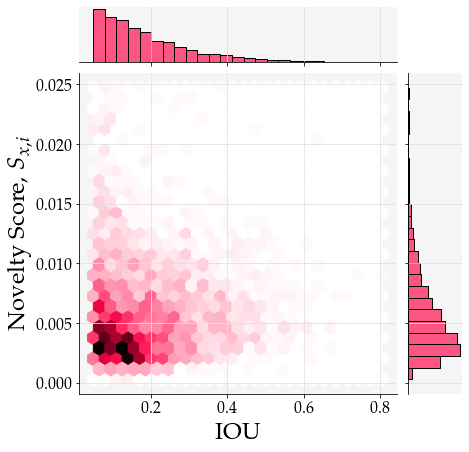

2021-05-24 14:19:15,807 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,810 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,811 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,811 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,812 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,812 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,812 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,812 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,813 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,813 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 

2021-05-24 14:19:15,852 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:15,853 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,854 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,855 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,856 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,856 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,856 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,857 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,857 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,857 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:

2021-05-24 14:19:15,903 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,903 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,903 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-24 14:19:15,904 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,905 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,906 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24 14:19:15,906 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-24 14:19:15,906 - DEBUG - family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
2021-05-24 14:19:15,907 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,907 - DEBUG - Textile font is not compatible with

BaselineAAE-bing1 2811


2021-05-24 14:19:15,942 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-24 14:19:15,945 - DEBUG - Textile font is not compatible with usetex.
2021-05-24 14:19:15,946 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-24 14:19:15,947 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,947 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-24 14:19:15,948 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-24 14:19:15,948 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-24 14:19:15,949 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-24 14:19:15,949 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-24 14:19:15,950 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-24

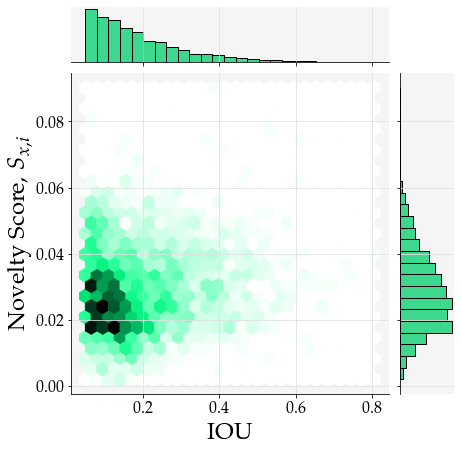

In [54]:
# View distibution of IoUs for typical and novel samples
for sn, res in iou_results.items():
    
    if 'AAE' in sn:
        color = 'C1'
    elif 'VAE' in sn:
        color = 'C6'
    else:
        color = 'C0'
    
    keep = res['ious'] > 0.05
    print(sn, sum(keep))
    
    plt.figure(figsize=(8, 8))
    sns.jointplot(x=res['ious'][keep], y=res['scores'][keep], color=color, kind='hex',
                  marginal_kws=dict(bins=25), joint_kws=dict(gridsize=25))
    plt.xlabel('IOU')
    plt.ylabel('Novelty Score, $S_{x,i}$')
    plt.savefig(f'iou-score-joint-distributions/LunarAnalogueRP-IOUvsRCScore-{sn}.pdf', bbox_inches='tight')
    plt.show()

In [15]:
# # Want to plot the novel-typical score overlap below
# typical_scores = scores[[not bool(b) for b in binary_labels]]

# novel_scores = scores[[bool(b) for b in binary_labels]]

# # plt.hist(scores, bins=25)
# plt.hist(novel_scores, bins=25, label='Novel', alpha=0.5)
# plt.hist(typical_scores, bins=25, label='Typical', alpha=0.5)

# plt.legend()
# plt.show()

NameError: name 'scores' is not defined

In [203]:
     
# ious = []
# # binary_labels = []  # IOU > 0.5 counts as a label
# n_duplicates = 0
# n_novelties = 428
# iou_thresh = 0.8

# gt_bboxes = res['gt_bboxes']
# print(gt_bboxes.shape)
# cr_bboxes = res['cr_bboxes']
# print(cr_bboxes.shape)
# print(cr_bboxes.max())

# for i, (gt, cr) in enumerate(zip(gt_bboxes.reshape(-1, 16, 4), cr_bboxes.reshape(-1, 16, 4))):
#     cr = cr * 5
#     if not (gt[0][2] == 0 or gt[0][2] == -1):
#         # Then there's a ground truth present
#         for gt_, cr_ in zip(gt, cr):
# #             print(gt_, cr_)
#             iou = metrics.iou(gt_, cr_)
# #             print(iou)
#             if iou > iou_thresh:
            
#                 fig, ax = plt.subplots()
#                 ax.imshow(plt.imread((res['filepaths'][i])))
#                 gt_rect = patches.Rectangle((gt_[0], gt_[1]), gt_[0]+gt_[2], gt_[1]+gt_[3], edgecolor='C0', facecolor='none', lw=3)
#                 cr_rect = patches.Rectangle((cr_[0], cr_[1]), cr_[2], cr_[3], edgecolor='C1', facecolor='none', lw=3)
#                 ax.add_patch(gt_rect)
#                 ax.add_patch(cr_rect)
#                 ax.grid(False)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.savefig(f'overlaps-from-datamodule/GoodIOU-{sn_tmp}-iou={int(iou*100)}.png', bbox_inches='tight')
#                 plt.close()

#                 fig, ax = plt.subplots()
#                 ax.imshow(plt.imread((res['filepaths'][i])))
#                 gt_rect = patches.Rectangle((gt_[0], gt_[1]), gt_[2], gt_[3], edgecolor='C0', facecolor='none', lw=3)
#                 ax.add_patch(gt_rect)
#                 for cr_ in cr:
#                     cr_rect = patches.Rectangle((cr_[0], cr_[1]), cr_[2], cr_[3], edgecolor='C1', facecolor='none', lw=3)
#                     ax.add_patch(cr_rect)
#                 ax.grid(False)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.savefig(f'overlaps-from-datamodule/AllRegions-{sn_tmp}-iou={int(iou*100)}.png', bbox_inches='tight')
#                 plt.close()    
        
        

(13312, 4)
(13312, 4)
357.0
